## DREAM MCMC : Aerosol size distributions

Built from PINTS mcmc tutorials: Bayesian inference on a time series, using [DREAM MCMC](http://pints.readthedocs.io/en/latest/mcmc/dream_mcmc.html) and [first sampling example](./first-example.ipynb).

Maura Dewey January 2025, original CCN closure code from Rahul Ranjan

Notebook for exploring/developing methodology


Sudo code, just to build framework for the sampling. We are not using the time-series capabilities of PINTS, because we are optmizing kappa at each timestep. But the code and framework is still faster/useful.

# 1. Import necessary libraries
import pints
import numpy as np
etc.

2 and onward is defined for one time-step of the CCN observations. So the forward model, everything below, is defined as a static model (defined once in the code), then the sampling step is run for each time-step in the observations time series. 

# 2. Define your forward model (the function mapping parameters -> output)
def forward_model(parameters):
    # Compute some output based on the input parameters
    return some_value_based_on(parameters)

# 3. Define the log-likelihood function
class CustomLogLikelihood(pints.LogPDF):
    def __init__(self):
        self.n_parameters = number_of_parameters  # Define the number of parameters

    def __call__(self, parameters):
        # Compute the "likelihood" (for DREAM, often using Bayesian formulation)
        output = forward_model(parameters)
        likelihood = some_probability_function(output)
        return likelihood  # Should return a log-probability

    def n_parameters(self):
        return self.n_parameters

# 4. Define the prior (e.g., uniform, Gaussian, etc.)
prior = pints.UniformLogPrior(lower_bounds, upper_bounds)  # Adjust bounds as needed

# 5. Define the posterior as the sum of likelihood and prior
log_posterior = pints.LogPosterior(CustomLogLikelihood(), prior)

# 6. Set up the MCMC sampler using DREAM
sampler = pints.MCMCController(log_posterior, chains=number_of_chains, method=pints.DreamMCMC)

# 7. Run the sampler
sampler.set_max_iterations(n_iterations)
samples = sampler.run()

# 8. Analyze the samples (e.g., plot distributions)


In [1]:
# 1. Import necessary libraries
import pints
import pints.plot
from pints.io import save_samples
from pints.io import load_samples
import numpy as np
import matplotlib.pyplot as plt
import os
import pandas as pd
import scipy.stats as stats
import seaborn as sns
from inv_ccn_utils import * #includes all CCN closure code from Rahul (execute test run, etc. as functions)
import time


In [68]:
# Import observations and parameters
obs_dir = 'input_data'                    

nsd_abs1 = pd.read_csv(os.path.join(obs_dir, 'NSD_mode1.csv'))  # Load NSD data for mode 1
nsd_abs2 = pd.read_csv(os.path.join(obs_dir, 'NSD_mode2.csv'))  # Load NSD data for mode 2
comp_obs = pd.read_csv(os.path.join(obs_dir, 'comp.csv'))  # Load observed composition data, mass fractions/concentrations
ccn_obs = pd.read_csv(os.path.join(obs_dir, 'CCN.csv'))  # Load observed CCN data
dp_dry = np.loadtxt('Dp.txt')  # Dry particle diameters in nanometers
M_org1_initial = pd.read_csv('M_org1_initialguess.csv') # Initial guess for organic mass fraction for mode 1
nedmead_results = pd.read_csv('result_nedler_mead_org0p12.csv') # Results from the Nedler-Mead optimization process
#bimodal_params_range = pd.read_csv(os.path.join(obs_dir,'bimodal_params_range.csv')) # max and min values for bimodal parameters, for uniform prior ranges.

#bimodal_params = pd.read_csv(os.path.join(obs_dir, 'Bimodal_parameters.csv'))  # Bimodal parameters for the model
#bimodal_mad = pd.read_csv(os.path.join(obs_dir, 'MAD.csv'), parse_dates=['datetime'])  # Bimodal median absolute deviation

#NSD_params_all = pd.read_csv(os.path.join(obs_dir, 'NSD_PARAMS_SCALED.csv'), parse_dates=['datetime'])  # Load all NSD parameters
#CCN_all = pd.read_csv(os.path.join(obs_dir, 'CCN_all.csv'), parse_dates=['datetime','start_time','end_time'])  # Load all CCN obs

bimodal_params = pd.read_csv(os.path.join(obs_dir, 'bimodal_params_windows.csv'), parse_dates=['datetime'])  # Bimodal parameters for the model

aerosol_mass = pd.read_csv(os.path.join(obs_dir, 'mass_from_median_NSDparams.csv'), parse_dates=['datetime'])  # Aerosol mass data
aerosol_mass_range = pd.read_csv(os.path.join(obs_dir, 'mass_highres_range.csv'), parse_dates=['datetime'])  # Aerosol mass range data

if not all(len(df) == len(nsd_abs1) for df in [nsd_abs2, comp_obs, ccn_obs]):
    raise ValueError('Obs dataframes have different lengths')

In [3]:
# Extra is a dictionary. First we fill in the constant parameters that are not changing at each iteration.
Extra = make_EXTRA(dp_dry)

#filter MAD to match bimodal_params:
#bimodal_mad = bimodal_mad[bimodal_mad['datetime'].isin(bimodal_params['datetime'])].reset_index(drop=True)

In [8]:
# Define forward model (the function mapping parameters -> output, here it's M_org1 + D1 + N1 -> total CCN at 5 supersaturations)

class CCNModel_mode1(pints.ForwardModel):
    # Calculate CCN, given the mass fraction of organics in the aitken mode, D1, N1 as the optimization parameters

    def __init__(self, Extra, dp_dry, NSD2_vec, GSD1, return_all=False):
        # Define the number of parameters and outputs:
        self._n_parameters = 3  # Number of optimization parameters
        self._n_outputs = 5 #number of outputs (CCN at 5 supersaturations)

        # Get pre-calculated/not-optimized parameters:
        self.Extra = Extra # Extra is a dictionary containing all constant parameters for the CCN closure calculation     
        self.dp_dry = dp_dry # dry particle diameters in nanometers
        self.NSD2_vec = NSD2_vec # NSD vector for mode 2  (first just have Mode 1 as optmization)
        self.GSD1 = GSD1 # geometric standard deviation for mode 1

        # Define the return_all flag: True, return all outputs (CCN, k_org, k_inorg, mass fractions, total masses). False, return only the total CCN (default for optimization)
        self.return_all = return_all

    
    def __call__(self, params):
        # unpack optimization parameters:
        M_org1 = params[0]  # Mass of organics in Aitken mode (optimization parameter)
        D1 = params[1]  # Median diameter of Aitken mode (optimization parameter)
        N1 = params[2]  # Median number concentration of Aitken mode (optimization parameter)

        # calculate size distribution for mode 1:
        NSD1 = size_distribution(np.array([[N1, self.GSD1, D1]]), self.Extra['dp']) # Aitken mode
        NSD1_vec = NSD1[1] # Aitken mode absolute NSD

        # calculate the mass of the particles in both modes:
        info_mass = cal_mass(self.dp_dry, self.Extra['true_inputs'], self.Extra, NSD1_vec, self.NSD2_vec)

        # get initial mass fractions for both modes:
        initial_M_BC1 = info_mass['M_BC1']  # Black carbon in Aitken mode
        initial_M_BC2 = info_mass['M_BC2']  # Black carbon in Accumulation mode
        tot_mass_org = info_mass['tot_org']
        tot_mass_AS = info_mass['tot_AS'] + info_mass['tot_AN']  # Total ammonium salts (sulfate + nitrate)
        initial_tot_acc_mass = info_mass['tot_mass_mode2']  # Total mass in Accumulation mode
        initial_tot_ait_mass = info_mass['tot_mass_mode1']  # Total mass in Aitken mode
 
        # Mass fractions for black carbon
        f_BC1 = initial_M_BC1 / initial_tot_ait_mass
        f_BC2 = initial_M_BC2 / initial_tot_acc_mass

        # Calculate remaining mass in each mode
        M_AS1 = initial_tot_ait_mass - (M_org1 + initial_M_BC1) # inorganics mass in mode1
        M_org2 = tot_mass_org - M_org1 #organics mass in mode2
        M_AS2 = tot_mass_AS - M_AS1 #inorganics mass in mode2
        total_ait_mass = M_org1 + M_AS1 + initial_M_BC1
        total_acc_mass = M_org2 + M_AS2 + initial_M_BC2

        #initial_total_mass = initial_tot_ait_mass + initial_tot_acc_mass # total mass of both modes
        initial_total_mass = info_mass['total_mass'] # total mass of both modes
        total_mass = total_ait_mass + total_acc_mass # total mass of both modes

        # Ensure masses are non-negative and within tolerance
        if(
        (0.99 * initial_total_mass < total_mass < 1.01 * initial_total_mass) and
        #(0.99 * initial_tot_ait_mass < total_ait_mass < 1.01 * initial_tot_ait_mass) and
        #(0.99 * initial_tot_acc_mass < total_acc_mass < 1.01 * initial_tot_acc_mass) and
        M_org2 >= 0 and M_AS2 >= 0 and M_AS1 >= 0 and M_org1 >= 0
        ):
            
        # If within tolerance, continue:
            f_org1 = M_org1 / total_ait_mass
            f_AS1 = M_AS1 / total_ait_mass
            f_org2 = M_org2 / total_acc_mass
            f_AS2 = M_AS2 / total_acc_mass
   
            mass_frac_aitken = [f_org1, 1, f_AS1, 0, f_BC1] # sequence is organics, total mass fraction, inorganics, nitrate, eBC
            mass_frac_accumulation = [f_org2, 1, f_AS2, 0, f_BC2]

            # calculate CCN, k_org, k_inorg for both modes:
            ccn1, k1, k_inorg1 = execute_test_run(mass_frac_aitken, self.Extra, NSD1_vec)
            ccn2, k2, k_inorg2 = execute_test_run(mass_frac_accumulation, self.Extra, self.NSD2_vec)
        
            # return CCN total:
            if self.return_all:
                return ccn1, ccn2, k1, k2, k_inorg1, k_inorg2, mass_frac_aitken, mass_frac_accumulation, total_ait_mass, total_acc_mass, total_mass, initial_total_mass,info_mass
            else:
                return ccn1+ccn2
        

        # If masses not within tolerance, return None (this will be penalized in the likelihood function)
        else:
            return None
    
    def n_parameters(self):
        return self._n_parameters
    
    def n_outputs(self):
        return self._n_outputs

In [ ]:
# Define forward model (the function mapping parameters -> output, here it's M_org1 -> total CCN)

class CCNModel(pints.ForwardModel):
    # Calculate CCN, given the mass fractions of organics in the aitken mode as the optimization parameter

    def __init__(self, Extra, info_mass, NSD1_vec, NSD2_vec, return_all=False):
        # Define the number of parameters and outputs:
        self._n_parameters = 1  # Number of parameters (currently only optimizing organic mass fraction)
        self._n_outputs = 5 #number of outputs (CCN at 5 supersaturations)

        # Get pre-calculated info (Extra, NSD1_vec, NSD2_vec, info_mass):
        self.Extra = Extra # Extra is a dictionary containing all constant parameters for the CCN closure calculation
        self.NSD1_vec = NSD1_vec # NSD for mode 1
        self.NSD2_vec = NSD2_vec # NSD for mode 2      
        self.info_mass = info_mass # total mass of particles in both modes

        # Define the return_all flag:
        # If True, return all outputs (CCN, k_org, k_inorg, mass fractions, total masses)
        # If False, return only the total CCN (default for optimization)
        self.return_all = return_all

    
    def __call__(self, M_org1):
        # Main function to calculate CCN given the mass of organics in the Aitken mode (M_org1)

        # get initial mass fractions for both modes:
        initial_M_BC1 = self.info_mass['M_BC1']  # Black carbon in Aitken mode
        initial_M_BC2 = self.info_mass['M_BC2']  # Black carbon in Accumulation mode
        tot_mass_org = self.info_mass['tot_org']
        tot_mass_AS = self.info_mass['tot_AS'] + self.info_mass['tot_AN']  # Total ammonium salts (sulfate + nitrate)
        initial_tot_acc_mass = self.info_mass['tot_mass_mode2']  # Total mass in Accumulation mode
        initial_tot_ait_mass = self.info_mass['tot_mass_mode1']  # Total mass in Aitken mode
 
        # Mass fractions for black carbon
        f_BC1 = initial_M_BC1 / initial_tot_ait_mass
        f_BC2 = initial_M_BC2 / initial_tot_acc_mass

        # Calculate remaining mass in each mode
        M_AS1 = initial_tot_ait_mass - (M_org1 + initial_M_BC1) # inorganics mass in mode1
        M_org2 = tot_mass_org - M_org1 #organics mass in mode2
        M_AS2 = tot_mass_AS - M_AS1 #inorganics mass in mode2
        total_ait_mass = M_org1 + M_AS1 + initial_M_BC1
        total_acc_mass = M_org2 + M_AS2 + initial_M_BC2

        # Ensure masses are non-negative and within tolerance
        if(
        (0.999 * initial_tot_ait_mass < total_ait_mass < 1.001 * initial_tot_ait_mass) and
        (0.999 * initial_tot_acc_mass < total_acc_mass < 1.001 * initial_tot_acc_mass) and
        M_org2 >= 0 and M_AS2 >= 0 and M_AS1 >= 0 and M_org1 >= 0
        ):
            
        # If within tolerance, continue:
            f_org1 = M_org1 / total_ait_mass
            f_AS1 = M_AS1 / total_ait_mass
            f_org2 = M_org2 / total_acc_mass
            f_AS2 = M_AS2 / total_acc_mass

            #tot_frac1_vec, tot_frac2_vec = f_org1 + f_AS1 + f_BC1, f_org2 + f_AS2 + f_BC2
    
            mass_frac_aitken = [f_org1, 1, f_AS1, 0, f_BC1] # sequence is organics, total mass fraction, inorganics, nitrate, eBC
            mass_frac_accumulation = [f_org2, 1, f_AS2, 0, f_BC2]

            # calculate CCN, k_org, k_inorg for both modes:
            ccn1, k1, k_inorg1 = execute_test_run(mass_frac_aitken, self.Extra, self.NSD1_vec)
            ccn2, k2, k_inorg2 = execute_test_run(mass_frac_accumulation, self.Extra, self.NSD2_vec)
        
            # return CCN total:
            if self.return_all:
                return ccn1, ccn2, k1, k2, k_inorg1, k_inorg2, mass_frac_aitken, mass_frac_accumulation, total_ait_mass, total_acc_mass
            else:
                return ccn1+ccn2
        

        # If masses not within tolerance, return None (this will be penalized in the likelihood function)
        else:
            return None
    
    def n_parameters(self):
        return self._n_parameters
    
    def n_outputs(self):
        return self._n_outputs

In [67]:
# Define forward model (the function mapping parameters -> output, here it's M_org1 + D1 + N1 + D2 + N2 -> total CCN at 5 supersaturations)

class CCNModel_modes(pints.ForwardModel):
    # Calculate CCN, given the mass fraction of organics in the aitken mode, D1, N1 as the optimization parameters

    def __init__(self, Extra, GSD1, GSD2, min_mass, max_mass, return_all=False):
        # Define the number of parameters and outputs:
        self._n_parameters = 5  # Number of optimization parameters
        self._n_outputs = 5 #number of outputs (CCN at 5 supersaturations)

        # Get pre-calculated/not-optimized parameters:
        self.Extra = Extra # Extra is a dictionary containing all constant parameters for the CCN closure calculation     
        self.GSD1 = GSD1 # geometric standard deviation for mode 1
        self.GSD2 = GSD2 # geometric standard deviation for mode 2
        self.min_mass = min_mass # minimum mass for optimization
        self.max_mass = max_mass # maximum mass for optimization

        # Define the return_all flag: True, return all outputs (CCN, k_org, k_inorg, mass fractions, total masses). False, return only the total CCN (default for optimization)
        self.return_all = return_all

    
    def __call__(self, params):
        # unpack optimization parameters:
        M_org1 = params[0]  # Mass of organics in Aitken mode (optimization parameter)
        D1 = params[1]  # Median diameter of Aitken mode (optimization parameter)
        N1 = params[2]  # Median number concentration of Aitken mode (optimization parameter)
        #GSD1 = params[3] # geometric standard deviation for Aitken mode (optimization parameter)
        D2 = params[3]  # Median diameter of Accumulation mode (optimization parameter)
        N2 = params[4]  # Median number concentration of Accumulation mode (optimization parameter)
        #GSD2 = params[6] # geometric standard deviation for Accumulation mode (optimization parameter)


        # calculate size distributions:
        NSD1 = size_distribution(np.array([[N1, self.GSD1, D1]]), self.Extra['dp']) # Aitken mode
        NSD1_vec = NSD1[1] # Aitken mode absolute NSD
        NSD2 = size_distribution(np.array([[N2, self.GSD2, D2]]), self.Extra['dp']) # Accumulation mode
        NSD2_vec = NSD2[1] # Accumulation mode absolute NSD

        # calculate the mass of the particles in both modes:
        info_mass = cal_mass(self.Extra['dp'], self.Extra['true_inputs'], self.Extra, NSD1_vec, NSD2_vec)

        # get initial mass fractions for both modes:
        initial_M_BC1 = info_mass['M_BC1']  # Black carbon in Aitken mode
        initial_M_BC2 = info_mass['M_BC2']  # Black carbon in Accumulation mode
        tot_mass_org = info_mass['tot_org']
        tot_mass_AS = info_mass['tot_AS'] + info_mass['tot_AN']  # Total ammonium salts (sulfate + nitrate)
        initial_tot_acc_mass = info_mass['tot_mass_mode2']  # Total mass in Accumulation mode
        initial_tot_ait_mass = info_mass['tot_mass_mode1']  # Total mass in Aitken mode
 
        # Mass fractions for black carbon
        f_BC1 = initial_M_BC1 / initial_tot_ait_mass
        f_BC2 = initial_M_BC2 / initial_tot_acc_mass

        # Calculate remaining mass in each mode
        M_AS1 = initial_tot_ait_mass - (M_org1 + initial_M_BC1) # inorganics mass in mode1
        M_org2 = tot_mass_org - M_org1 #organics mass in mode2
        M_AS2 = tot_mass_AS - M_AS1 #inorganics mass in mode2
        total_ait_mass = M_org1 + M_AS1 + initial_M_BC1
        total_acc_mass = M_org2 + M_AS2 + initial_M_BC2

        # Check total mass:
        total_mass = total_ait_mass + total_acc_mass # total mass of both modes with optimized parameters

        # Ensure mass is non-negative and within tolerance
        if(
        #(0.9 * self.med_mass < total_mass < 1.1 * self.med_mass) and
        (self.min_mass < total_mass < self.max_mass) and
        M_org2 >= 0 and M_AS2 >= 0 and M_AS1 >= 0 and M_org1 >= 0
        ):
            
        # If within tolerance, continue:
            f_org1 = M_org1 / total_ait_mass
            f_AS1 = M_AS1 / total_ait_mass
            f_org2 = M_org2 / total_acc_mass
            f_AS2 = M_AS2 / total_acc_mass
   
            mass_frac_aitken = [f_org1, 1, f_AS1, 0, f_BC1] # sequence is organics, total mass fraction, inorganics, nitrate, eBC
            mass_frac_accumulation = [f_org2, 1, f_AS2, 0, f_BC2]

            # calculate CCN, k_org, k_inorg for both modes:
            ccn1, k1, k_inorg1 = execute_test_run(mass_frac_aitken, self.Extra, NSD1_vec)
            ccn2, k2, k_inorg2 = execute_test_run(mass_frac_accumulation, self.Extra, NSD2_vec)
        
            # return CCN total:
            if self.return_all:
                return ccn1, ccn2, k1, k2, k_inorg1, k_inorg2, mass_frac_aitken, mass_frac_accumulation, total_ait_mass, total_acc_mass, total_mass,info_mass, NSD1_vec, NSD2_vec
            else:
                return ccn1+ccn2
        

        # If masses not within tolerance, return None (this will be penalized in the likelihood function)
        else:
            return None
    
    def n_parameters(self):
        return self._n_parameters
    
    def n_outputs(self):
        return self._n_outputs

In [5]:
# Define the log-likelihood function

class GaussianLogLikelihood(pints.LogPDF):
    def __init__(self, model, observed_data):
        """
        Custom Gaussian log-likelihood with sigma as an optimizable parameter.

        Parameters:
        - model: A callable forward model.
        - observed_data: Observed dataset (numpy array).
        """
        self.model = model
        self.observed_data = np.array(observed_data)
        self.n_model_parameters = model.n_parameters() # Number of model parameters
        self.n_total_parameters = model.n_parameters() + model.n_outputs()  # total number of parameters (model parameters + sigma)

    def __call__(self, parameters):
        """Compute Gaussian log-likelihood where sigma is also optimized."""
        model_parameters = parameters[:self.n_model_parameters]  # Model parameters
        sigma = np.array(parameters[self.n_model_parameters:])  # Last elements are sigma values
        
        # Ensure all sigma values are positive
        if np.any(sigma <= 0):
            return -np.inf  # Reject invalid sigmas

        total_ccn = self.model(model_parameters) # Call the model with parameters

        # If model returns None (invalid parameters), reject sample
        if total_ccn is None:
            return -np.inf

        # Convert model output to numpy array
        total_ccn = np.array(total_ccn)

        # Ensure model output shape matches observed data
        if total_ccn.shape != self.observed_data.shape:
            return -np.inf

        # Compute residuals
        residuals = self.observed_data - total_ccn

        # Compute log-likelihood
        log_likelihood = -0.5 * np.sum((residuals / sigma) ** 2) - np.sum(np.log(sigma)) - 0.5 * self.observed_data.size * np.log(2 * np.pi)

        return log_likelihood

    def n_parameters(self):
        """Return the number of parameters expected (including one sigma per output)."""
        return self.n_total_parameters



In [5]:
# Define known sigma log-likelihood function
class KnownSigmaGaussianLogLikelihood(pints.LogPDF):
    def __init__(self, model, observed_data):
        """
        Custom Gaussian log-likelihood with known measurement noise (sigma).

        Parameters:
        - model: A callable forward model.
        - observed_data: Observed dataset (numpy array).
        - sigma: Known observation noise (numpy array or scalar; currently set to 10% of observed data).
        """
        self.model = model
        self.observed_data = np.array(observed_data)
        self._no = model.n_outputs() # Number of model outputs (CCN at 5 supersaturations)
        self._np = model.n_parameters() # total number of parameters (just model parameters)
        
        # for now we assume sigma is 10% of the observed data
        sigma = 0.1 * self.observed_data
        
        # Ensure all sigma values are positive floats
        if np.isscalar(sigma):
            sigma = np.ones(self._no) * float(sigma)  # Convert to array if scalar
        else:
            sigma = pints.vector(sigma)  # Ensure it's a numpy array
            if len(sigma) != self._no:
                raise ValueError("Sigma must have the same length as the number of outputs.")
        
        if np.any(sigma <= 0):
            raise ValueError("Sigma values must be positive.")
        
        # pre-calculate parts:
        self._offset = -0.5 * np.log(2 * np.pi)
        self._offset -= np.log(sigma)
        self._multip = -1 / (2.0 * sigma**2)
        
    def __call__(self, parameters):
        """Compute Gaussian log-likelihood with known sigma."""
        total_ccn = self.model(parameters) # Call the model with parameters

        # If model returns None (invalid parameters), reject sample
        if total_ccn is None:
            return -np.inf

        # Convert model output to numpy array
        total_ccn = np.array(total_ccn)

        # Ensure model output shape matches observed data
        if total_ccn.shape != self.observed_data.shape:
            return -np.inf

        # Compute residuals
        residuals = self.observed_data - total_ccn

        # Compute log-likelihood
        log_likelihood = np.sum(self._offset + self._multip * np.sum(residuals**2, axis=0))

        return log_likelihood

    def n_parameters(self):
        """Return the number of parameters expected."""
        return self._np

In [69]:
# Setup optmization loop:

#create array to hold results:
ccn_sigma_mean = [] # mean of sigma for each observation
ccn_sigma_std = [] # std of sigma for each observation
all_output = [] # CCN model outputs for each observation

# some settings for MCMC:
#warmup = 1000 # Number of warmup iterations to discard
max_iterations = 10000 # Number of iterations to run in total
n_chains = 4 # Number of MCMC chains to run in parallel

#Loop through CCN observations:
for i in range(20,21): #range(len(nsd_abs1)):

# Set up ------------------

    # add mass_frac observations to the Extra dictionary:
    mass_frac = [
        comp_obs['Org'][i],         # Mass fractions of the components in the particles: [Org, Other, NH4SO4, NH4NO3, BC].
        comp_obs['total_mass'][i],
        comp_obs['NH4SO4'][i],
        comp_obs['NH4NO3'][i],
        comp_obs['eBC880'][i]
        ]

    # mass vectors:
    mass_vec_NH4SO4 = comp_obs['NH4SO4'][i] * comp_obs['total_mass'][i]
    mass_vec_NH4NO3 = comp_obs['NH4NO3'][i] * comp_obs['total_mass'][i]

    # mass fractions
    mass_frac_vec_NH4SO4 = mass_vec_NH4SO4 / (mass_vec_NH4SO4 + mass_vec_NH4NO3)
    mass_frac_vec_NH4NO3 = mass_vec_NH4NO3 / (mass_vec_NH4SO4 + mass_vec_NH4NO3)

    # densities:
    rho_sulp = Extra['densities'][1]   # in kg/m^3
    rho_nitr = Extra['densities'][2]

    # get inorganic density (we include both NH4SO4 and NH4NO3)
    rho_inorg = (mass_frac_vec_NH4SO4 * rho_sulp) + (mass_frac_vec_NH4NO3 * rho_nitr)

    # add to Extra the variables that are calculated each time step:
    Extra['true_inputs'] = mass_frac
    Extra['rho_inorg'] = rho_inorg

    # load mode 2 NSD vector:
    #NSD2_vec = np.array(nsd_abs2.iloc[i,1:].values) # NSD for mode 2

    # load CCN observations:
    response = np.array(ccn_obs.iloc[i,1:].values) # CCN observations at 5 supersaturations

    #create instance of the model:
    #m = CCNModel(Extra, info_mass, NSD1_vec, NSD2_vec)
    #m = CCNModel_mode1(Extra, dp_dry, NSD2_vec, bimodal_params['mode1_sigma'][i])
    
    m = CCNModel_modes(Extra, bimodal_params['mode1_sigma'][i], bimodal_params['mode2_sigma'][i], aerosol_mass_range['min mass (ug/m3)'][i], aerosol_mass_range['max mass (ug/m3)'][i])


# setup PINTS optimization--------------

    # Priors:

    M_org1_prior = pints.HalfCauchyLogPrior(0,0.08)

    #D1_prior = pints.GaussianLogPrior(bimodal_params['mode1_d'][i], bimodal_params['mode1_d'][i]*0.5) # Gaussian prior for D1
    #N1_prior = pints.GaussianLogPrior(bimodal_params['mode1_n'][i], bimodal_params['mode1_n'][i]*0.5) # Gaussian prior for N1

    #D1_prior = pints.UniformLogPrior(bimodal_params_range['mode1_d_min'][i], bimodal_params_range['mode1_d_max'][i])
    #N1_prior = pints.UniformLogPrior(bimodal_params_range['mode1_n_min'][i], bimodal_params_range['mode1_n_max'][i])
    #D2_prior = pints.UniformLogPrior(bimodal_params_range['mode2_d_min'][i], bimodal_params_range['mode2_d_max'][i])
    #N2_prior = pints.UniformLogPrior(bimodal_params_range['mode2_n_min'][i], bimodal_params_range['mode2_n_max'][i])

    D1_prior = pints.CauchyLogPrior(bimodal_params['mode1_d'][i], bimodal_params['mode1_d_mad'][i]) # Cauchy prior for D1, with scale parameter from MAD
    D2_prior = pints.CauchyLogPrior(bimodal_params['mode2_d'][i], bimodal_params['mode2_d_mad'][i]) # Cauchy prior for D2, with scale parameter from MAD
    N1_prior = pints.CauchyLogPrior(bimodal_params['NSD1_sum'][i], bimodal_params['mode1_NSD_mad'][i]) # Cauchy prior for N1, with scale parameter from MAD
    N2_prior = pints.CauchyLogPrior(bimodal_params['NSD2_sum'][i], bimodal_params['mode2_NSD_mad'][i]) # Cauchy prior for N2, with scale parameter from MAD

    #M_org1_prior = pints.GaussianLogPrior(M_org1_initial['M_org1'][i], M_org1_initial['M_org1'][i]*0.5) # Gaussian prior for M_org1

    #GSD1_prior = pints.GaussianLogPrior(bimodal_params['mode1_sigma'][i], bimodal_params['mode1_sigma'][i]*0.5) # Gaussian prior for GSD1
    #GSD2_prior = pints.GaussianLogPrior(bimodal_params['mode2_sigma'][i], bimodal_params['mode2_sigma'][i]*0.5) # Gaussian prior for GSD2

    # Uniform log-prior for observational noise (between 0 and 0.2*observed data)
    #low = 0.0 # Lower bound for sigma 
    #high = np.ceil(np.array(response)*0.2) # Upper bound for sigma, 20% of observed data
    #sigma_prior = [pints.UniformLogPrior(low, high[i]) for i in range(5)]  # uniform sigma prior

    # Combine priors into a single log-prior
    joint_prior = pints.ComposedLogPrior(M_org1_prior, D1_prior, N1_prior, D2_prior, N2_prior)
   
    # Define the posterior as the sum of likelihood and prior
    log_posterior = pints.LogPosterior(KnownSigmaGaussianLogLikelihood(m, response), joint_prior)

    # set initial parameter values for each chain:
    initial_guess = [M_org1_initial['M_org1'][i], bimodal_params['mode1_d'][i], bimodal_params['NSD1_sum'][i], bimodal_params['mode2_d'][i], bimodal_params['NSD2_sum'][i]] # Initial guesses for M_org1, D1, N1, D2, N2
    initial_parameters = np.array(initial_guess)
    x0 = [
        initial_parameters*0.98,
        initial_parameters*0.99,
        initial_parameters*1.0,
        initial_parameters*1.01,
        ]

    # setup optimisation controller
    mcmc = pints.MCMCController(log_posterior, n_chains, x0, method=pints.DreamMCMC) # inputs: log_pdf, number of MCMC chains, initial points, method 
    mcmc.set_initial_phase_iterations(200)
    mcmc.set_max_iterations(max_iterations) # Set the maximum number of iterations
    mcmc.set_log_to_screen(False)

    # Run!
    print('Running...',i,'/100') # add i to print statement, as percentage of total?
    samples = mcmc.run()
    print('Done!')



Running... 20 /100


c:\Users\made2928\OneDrive\Documents\MISU\Modal Aerosol Composition\inv_ccn_utils.py:273: RuntimeWarning: invalid value encountered in log10
  num = (np.log10(bins) - np.log10(dp))**2


Done!


In [25]:
samples.shape

(4, 6000, 7)

In [87]:
# save outputs for this iteration--------------

#save all chains for M_org1 optimization:
timestr = time.strftime("%Y%m%d-%H%M%S")
save_samples('chains/MCMC_M_org1_samples_idx'+str(i)+'_'+timestr+'.csv', samples[:, :, 0])
save_samples('chains/MCMC_D1_samples_idx'+str(i)+'_'+timestr+'.csv', samples[:, :, 1])
save_samples('chains/MCMC_N1_samples_idx'+str(i)+'_'+timestr+'.csv', samples[:, :, 2])
save_samples('chains/MCMC_D2_samples_idx'+str(i)+'_'+timestr+'.csv', samples[:, :, 3])
save_samples('chains/MCMC_N2_samples_idx'+str(i)+'_'+timestr+'.csv', samples[:, :, 4])
#save_samples('chains/MCMC_GSD1_samples_idx'+str(i)+'_'+timestr+'.csv', samples[:, :, 3])

#save mean and std for measurement noise:
#ccn_sigma_mean.append(samples[:, warmup:, 1:].mean(axis=(0,1)))
#ccn_sigma_std.append(samples[:, warmup:, 1:].std(axis=(0,1)))

#save CCN model outputs:
#m_out = CCNModel_mode1(Extra, dp_dry, NSD2_vec, bimodal_params['mode1_n'][i], bimodal_params['mode1_sigma'][i], return_all=True) #first create a new model instance with return_all=True
#m_out = CCNModel(Extra, info_mass, NSD1_vec, NSD2_vec, return_all=True) #first create a new model instance with return_all=True
#all_output.append(m_out([samples[:, warmup:, 0].mean(), samples[:, warmup:, 1].mean(), samples[:, warmup:, 2], samples[:, warmup:, 3]])) # get all outputs using optimized M_org1


#mean_M_org1.append(samples[:, warmup:, :].mean())
#std_M_org1.append(samples[:, warmup:, :].std())
#percentiles.append(np.percentile(samples[:,warmup:,:].reshape(-1,1), [2.5, 50, 97.5]))
#rhat.append(pints.rhat(samples[:, warmup:, :]))
#ess.append(pints.effective_sample_size(samples[:, warmup:, :].reshape(-1,1)))

In [118]:
import numpy as np
from scipy.special import gamma

# Custom log of Student's t-distribution log-prior
def student_t_log_prior(x, location, df, scale):
    term1 = gamma((df + 1) / 2) / (np.sqrt(df * np.pi) * scale * gamma(df / 2))
    term2 = (1 + ((x - location)**2) / (df * scale**2))**(- (df + 1) / 2)
    return np.log(term1 * term2)

# Example usage
D1_location = bimodal_params['mode1_d'][i]
df = 3
scale = 10

# Check initial guesses
for factor in [0.1, 0.2, 0.5, 1.0]:
    guess = bimodal_params['mode1_d'][i] * factor
    
    try:
        log_prior_value = student_t_log_prior(guess, D1_location, df, scale)
        print(f"Initial guess: {guess}, log prior: {log_prior_value}")
    except Exception as e:
        print(f"Error with guess {guess}: {str(e)}")

Initial guess: 3.710171409845705, log prior: -6.405671720338909
Initial guess: 7.42034281969141, log prior: -6.044115192807138
Initial guess: 18.550857049228522, log prior: -4.831723474271448
Initial guess: 37.101714098457045, log prior: -3.3034739426175554


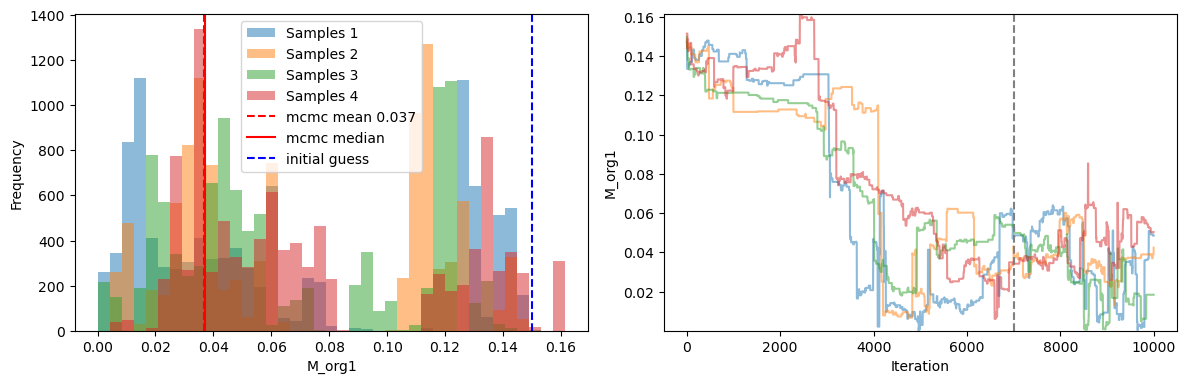

In [77]:
burn_in = 7000 # Discard the first samples (burn-in period)

plt_samples = samples[:,:,0:1]

f,axs = pints.plot.trace(plt_samples[:, :, :], parameter_names=['M_org1'])
f.set_figheight(5)
axs[0][0].axvline(x=plt_samples[:, burn_in:, :].mean(), color='r', linestyle='--', label='mcmc mean '+str(np.round(plt_samples[:, burn_in:, :].mean(),3)))
axs[0][0].axvline(x=np.median(plt_samples[:, burn_in:, :]), color='r', label='mcmc median')
axs[0][0].axvline(x=M_org1_initial['M_org1'][i], color='b', linestyle='--', label='initial guess')
axs[0][0].legend()
axs[0][1].axvline(x=burn_in, color='grey', linestyle='--')

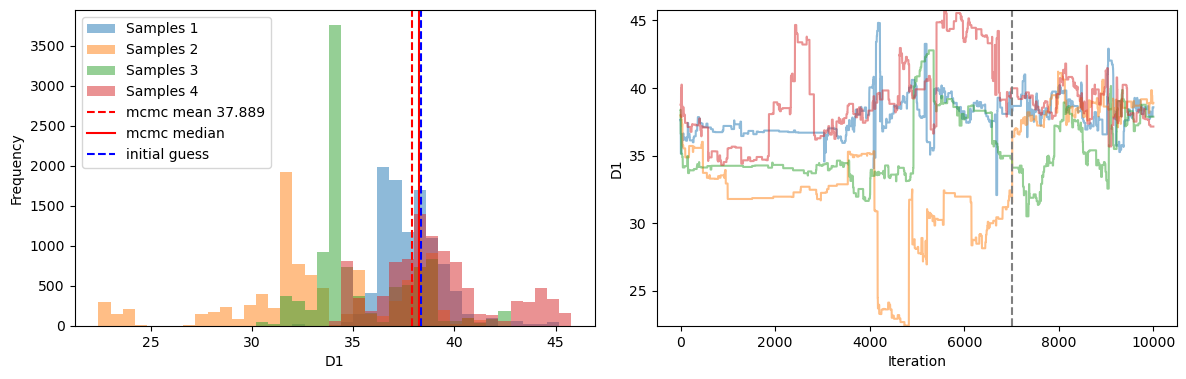

In [78]:
plt_samples = samples[:,:,1:2]
f,axs = pints.plot.trace(plt_samples[:, :, :], parameter_names=['D1'])
f.set_figheight(5)
axs[0][0].axvline(x=plt_samples[:, burn_in:, :].mean(), color='r', linestyle='--', label='mcmc mean '+str(np.round(plt_samples[:, burn_in:, :].mean(),3)))
axs[0][0].axvline(x=np.median(plt_samples[:, burn_in:, :]), color='r', label='mcmc median')
axs[0][0].axvline(x=bimodal_params['mode1_d'][i], color='b', linestyle='--', label='initial guess')
axs[0][0].legend()
axs[0][1].axvline(x=burn_in, color='grey', linestyle='--')

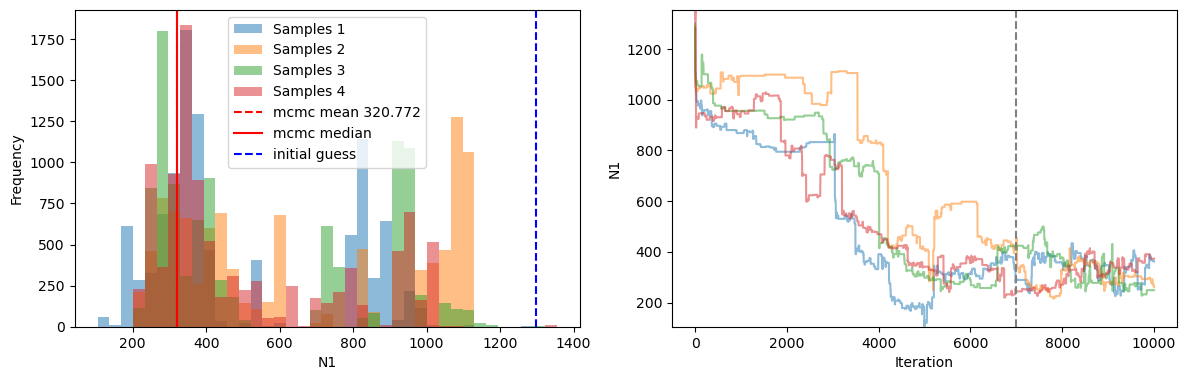

In [79]:
plt_samples = samples[:,:,2:3]
f,axs = pints.plot.trace(plt_samples[:, :, :], parameter_names=['N1'])
f.set_figheight(5)
axs[0][0].axvline(x=plt_samples[:, burn_in:, :].mean(), color='r', linestyle='--', label='mcmc mean '+str(np.round(plt_samples[:, burn_in:, :].mean(),3)))
axs[0][0].axvline(x=np.median(plt_samples[:, burn_in:, :]), color='r', label='mcmc median')
axs[0][0].axvline(x=bimodal_params['mode1_n'][i], color='b', linestyle='--', label='initial guess')
axs[0][0].legend()
axs[0][1].axvline(x=burn_in, color='grey', linestyle='--')

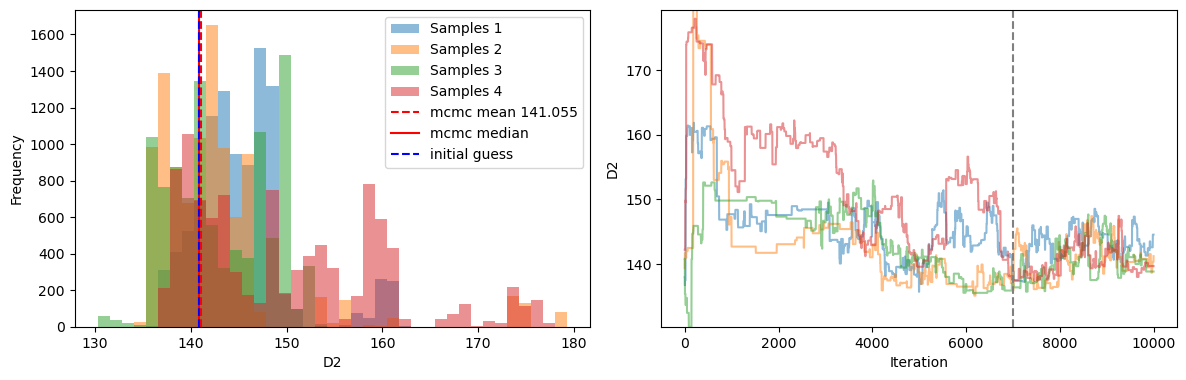

In [80]:
plt_samples = samples[:,:,3:4]
f,axs = pints.plot.trace(plt_samples[:, :, :], parameter_names=['D2'])
f.set_figheight(5)
axs[0][0].axvline(x=plt_samples[:, burn_in:, :].mean(), color='r', linestyle='--', label='mcmc mean '+str(np.round(plt_samples[:, burn_in:, :].mean(),3)))
axs[0][0].axvline(x=np.median(plt_samples[:, burn_in:, :]), color='r', label='mcmc median')
axs[0][0].axvline(x=bimodal_params['mode2_d'][i], color='b', linestyle='--', label='initial guess')
axs[0][0].legend()
axs[0][1].axvline(x=burn_in, color='grey', linestyle='--')

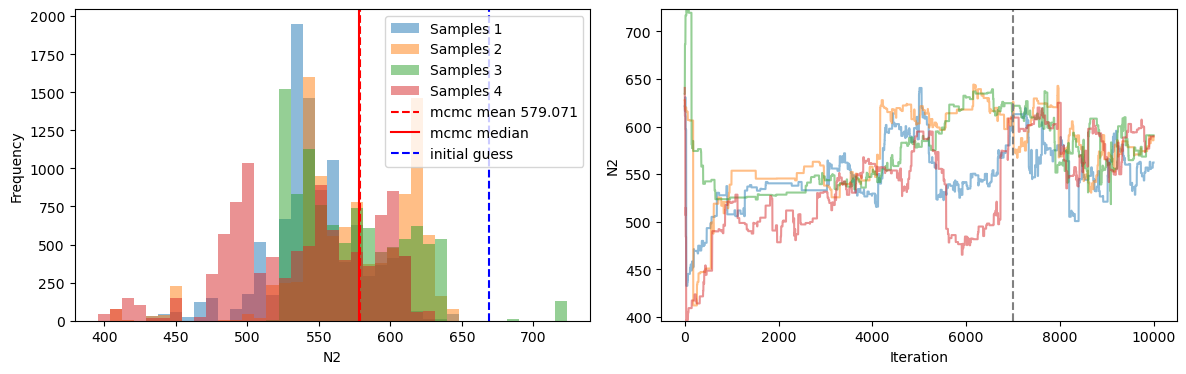

In [81]:
plt_samples = samples[:,:,4:5]
f,axs = pints.plot.trace(plt_samples[:, :, :], parameter_names=['N2'])
f.set_figheight(5)
axs[0][0].axvline(x=plt_samples[:, burn_in:, :].mean(), color='r', linestyle='--', label='mcmc mean '+str(np.round(plt_samples[:, burn_in:, :].mean(),3)))
axs[0][0].axvline(x=np.median(plt_samples[:, burn_in:, :]), color='r', label='mcmc median')
axs[0][0].axvline(x=bimodal_params['mode2_n'][i], color='b', linestyle='--', label='initial guess')
axs[0][0].legend()
axs[0][1].axvline(x=burn_in, color='grey', linestyle='--')

In [76]:
plt_samples = samples[:,:,5:6]
f,axs = pints.plot.trace(plt_samples[:, :, :], parameter_names=['N2'])
f.set_figheight(5)
axs[0][0].axvline(x=plt_samples[:, burn_in:, :].mean(), color='r', linestyle='--', label='mcmc mean '+str(np.round(plt_samples[:, burn_in:, :].mean(),3)))
axs[0][0].axvline(x=np.median(plt_samples[:, burn_in:, :]), color='r', label='mcmc median')
axs[0][0].axvline(x=bimodal_params['mode2_n'][i], color='b', linestyle='--', label='initial guess')
axs[0][0].legend()
axs[0][1].axvline(x=burn_in, color='grey', linestyle='--')

ValueError: Length of `parameter_names` must be same as number of parameters.

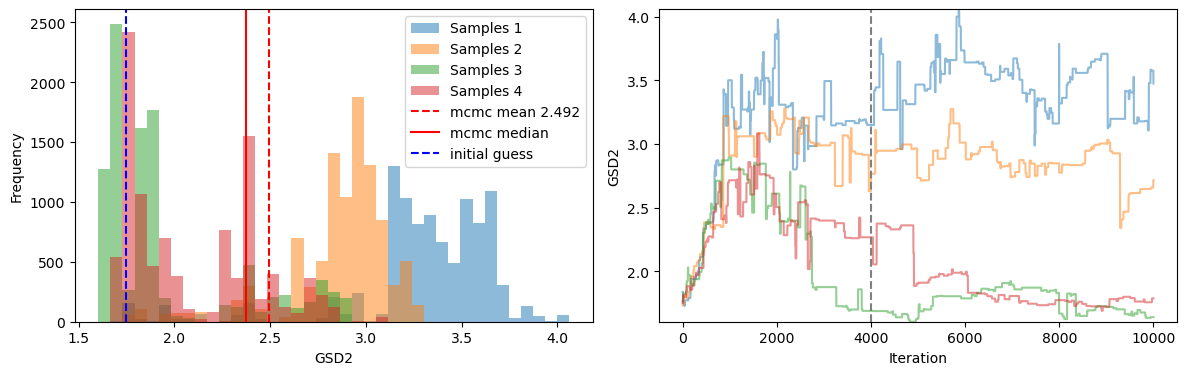

In [75]:
plt_samples = samples[:,:,6:7]
f,axs = pints.plot.trace(plt_samples[:, :, :], parameter_names=['GSD2'])
f.set_figheight(5)
axs[0][0].axvline(x=plt_samples[:, burn_in:, :].mean(), color='r', linestyle='--', label='mcmc mean '+str(np.round(plt_samples[:, burn_in:, :].mean(),3)))
axs[0][0].axvline(x=np.median(plt_samples[:, burn_in:, :]), color='r', label='mcmc median')
axs[0][0].axvline(x=bimodal_params['mode2_sigma'][i], color='b', linestyle='--', label='initial guess')
axs[0][0].legend()
axs[0][1].axvline(x=burn_in, color='grey', linestyle='--')

(<Figure size 1500x1500 with 25 Axes>,
 array([[<Axes: ylabel='Frequency'>, <Axes: >, <Axes: >, <Axes: >,
         <Axes: >],
        [<Axes: ylabel='D1'>, <Axes: >, <Axes: >, <Axes: >, <Axes: >],
        [<Axes: ylabel='N1'>, <Axes: >, <Axes: >, <Axes: >, <Axes: >],
        [<Axes: ylabel='D2'>, <Axes: >, <Axes: >, <Axes: >, <Axes: >],
        [<Axes: xlabel='M_org1', ylabel='N2'>, <Axes: xlabel='D1'>,
         <Axes: xlabel='N1'>, <Axes: xlabel='D2'>, <Axes: xlabel='N2'>]],
       dtype=object))

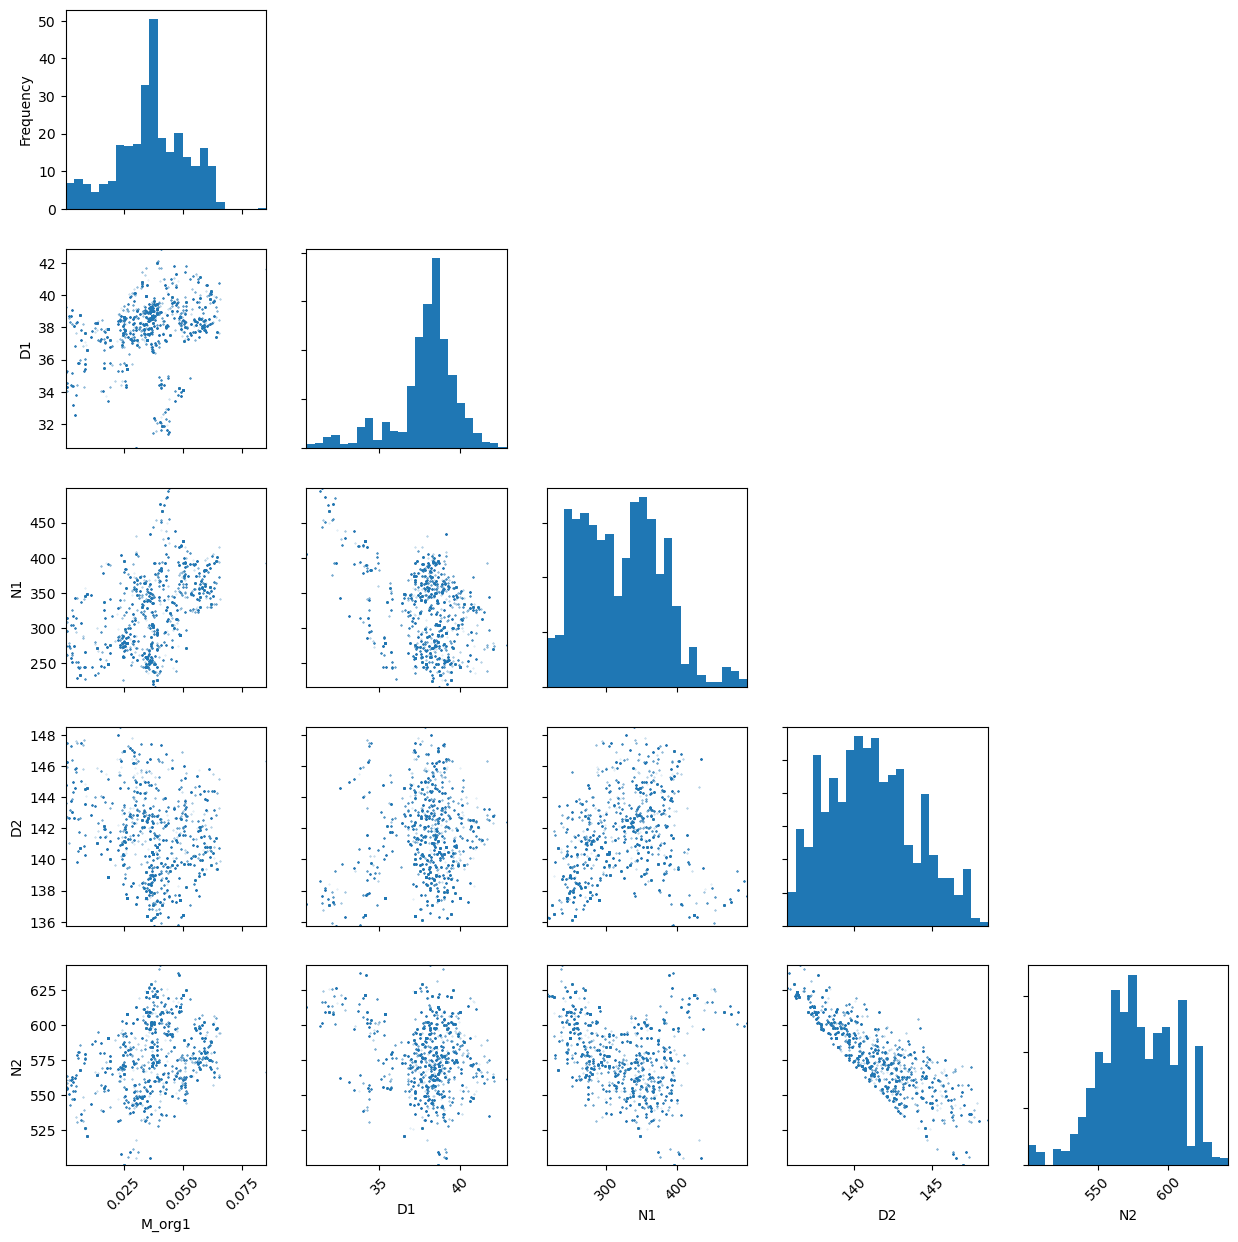

In [82]:
pints.plot.pairwise(np.vstack(samples[:,burn_in:,:]), kde=False, parameter_names=['M_org1', 'D1', 'N1', 'D2', 'N2'])

In [84]:
m_out = CCNModel_modes(Extra, bimodal_params['mode1_sigma'][i], bimodal_params['mode2_sigma'][i], aerosol_mass_range['min mass (ug/m3)'][i], aerosol_mass_range['max mass (ug/m3)'][i], return_all=True)


In [85]:
test_output = m_out([0.037,37.889,320.772,141.055,579.071])

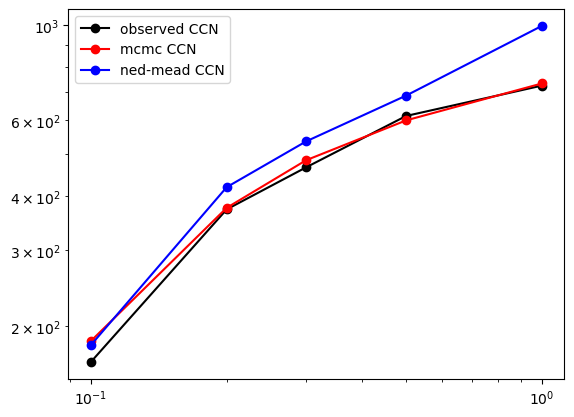

In [86]:
ss = [0.1,0.2,0.3,0.5,1.0]

nedmed_ccn = np.fromstring(nedmead_results['Predicted_CCN'][i].strip('[]'), sep=' ') 

plt.loglog(ss, response, label='observed CCN', color='k', marker='o')
plt.loglog(ss, test_output[0]+test_output[1], label='mcmc CCN', color='r', marker='o')
plt.loglog(ss, nedmed_ccn, label='ned-mead CCN', color='b', marker='o')
plt.legend()

In [58]:
test_output[8]+test_output[9] # total mass in both modes

4.783007494984658

In [45]:
comp_obs.iloc[i]

datetime      2016-08-18 19:00:00
Org                      0.680098
NH4SO4                   0.235083
NH4NO3                   0.020468
eBC880                   0.064351
total_mass               3.848644
Name: 20, dtype: object

In [70]:
test_output[13].sum()

271.46318187184124

In [71]:
test_output[14].sum()

605.4811482330383

In [56]:
outputdf=pd.DataFrame(all_output,columns=['ccn1', 'ccn2', 'k1', 'k2', 'k_inorg1', 'k_inorg2', 'mass_frac_aitken', 'mass_frac_accumulation', 'total_ait_mass', 'total_acc_mass'])
outputdf.to_csv('chains/MCMC_M_org1_idx0_9_output.csv')

In [64]:
nsd_abs1

,datetime,c2.82c,c3.16c,c3.55c,c3.98c,c4.47c,c5.01c,c5.62c,c6.31c,c7.08c,...,c355.0c,c398.0c,c447.0c,c501.0c,c562.0c,c631.0c,c708.0c,c794.0c,c891.0c,c1000.0c
0,2016-08-16 09:00:00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,1.880042e-02,7.219432e-03,2.231036e-03,6.441793e-04,1.116288e-04,3.870874e-05,1.698337e-05,4.402069e-06,1.723549e-06,4.371158e-06
1,2016-08-16 11:00:00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,1.842539e-02,5.923191e-03,1.580921e-03,4.092835e-04,1.586778e-04,3.443658e-05,1.893807e-05,7.077525e-06,1.086056e-08,2.915296e-08
2,2016-08-16 13:00:00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,3.591470e-03,9.721400e-04,2.329275e-04,6.171727e-05,2.357713e-05,9.085832e-06,3.264196e-06,9.036410e-07,1.006054e-07,2.547793e-07
3,2016-08-16 15:00:00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,3.832487e-03,1.138440e-03,3.137930e-04,6.491215e-05,1.705424e-05,1.545076e-05,6.132921e-06,1.180072e-06,9.693986e-07,1.568513e-06
4,2016-08-17 11:00:00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.505310,3.262255,2.933546,...,4.135203e-02,1.465610e-02,3.968942e-03,4.382002e-04,5.764531e-04,1.465263e-04,1.060457e-04,2.716647e-05,2.387183e-06,4.720152e-06
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6575,2020-04-01 11:00:00,21.639286,14.028704,3.231404,16.916522,25.830951,24.411615,32.742026,41.865735,58.565528,...,1.020040e-03,5.258278e-04,4.264489e-04,3.508892e-04,4.471686e-04,6.158278e-04,6.505304e-04,5.386145e-04,4.960426e-04,4.667639e-04
6576,2020-04-01 15:00:00,10.077137,21.020513,36.769760,46.848331,69.211145,117.068818,187.493309,254.949703,265.194419,...,1.022084e-10,2.870470e-11,6.926039e-12,1.910819e-12,3.056906e-13,6.684782e-14,1.168983e-14,3.730719e-15,2.025209e-17,8.698658e-17
6577,2020-04-01 17:00:00,32.177399,43.283772,33.541329,57.656186,80.964185,110.201299,167.028283,227.507764,260.226009,...,3.601288e-13,3.651664e-14,1.802374e-15,5.951568e-17,2.426523e-16,1.796936e-17,2.120369e-18,5.178161e-19,2.201318e-20,9.948562e-21
6578,2020-04-01 19:00:00,13.607996,13.719235,12.729706,26.883773,43.496700,34.956885,60.293609,99.759004,139.873584,...,1.391752e-04,8.964046e-05,6.833848e-05,4.927363e-05,6.603621e-05,1.247531e-04,2.584011e-04,4.402899e-04,2.800062e-04,3.664132e-04


In [48]:
f_org1 = []
for i in range(10):
    print(outputdf['mass_frac_aitken'][i][0])


0.13904265805347596
0.14799093356282383
0.9285308891939046
0.8360452782570061
0.35493646961753345
0.26587243579421777
0.6053589211032594
0.4853412606177445
0.6651402936071852
0.7534526432886984


In [45]:
nedmead_results = pd.read_csv('result_nedler_mead_org0p12.csv')
nedmead_results[0:10]['f_org1'].values

array([2.24253781e-04, 2.41189357e-04, 9.55982737e-01, 9.42483156e-01,
       5.34998160e-01, 4.34428069e-01, 9.47496092e-01, 8.11593453e-01,
       9.37458489e-01, 9.36496517e-01])

In [51]:
(outputdf['ccn1']+outputdf['ccn2']).values # total CCN from the model

array([array([ 82.19625401, 139.87572331, 169.93706877, 213.90047134,
              257.54181873])                                         ,
       array([110.01443658, 184.15906298, 219.11297476, 265.16269212,
              295.56498333])                                         ,
       array([135.33805633, 208.42544053, 230.73539543, 257.17815969,
              299.81530581])                                         ,
       array([101.06201642, 218.09748807, 249.86187345, 294.63160357,
              362.00393258])                                         ,
       array([115.61542272, 293.65346696, 402.81991558, 620.44109894,
              841.9119434 ])                                         ,
       array([124.06517654, 305.77615604, 433.24445906, 662.71432897,
              850.91814008])                                         ,
       array([ 90.24189801, 337.62910041, 491.91847424, 708.89862087,
              925.74453764])                                         ,
       array(

In [50]:
nedmead_results[0:10]['Predicted_CCN'].values

array(['[ 82.63042095 141.49618239 174.54355345 218.58103063 260.36721824]',
       '[110.43237989 185.84076701 223.53819704 268.92372245 297.20032097]',
       '[135.32896002 208.15472166 230.35706304 256.14713121 297.29800116]',
       '[101.24933555 216.77225436 247.70126095 286.65162092 349.3122521 ]',
       '[115.71435684 280.32094412 370.73743266 574.60032714 813.39360348]',
       '[125.41476931 296.04006445 396.91050044 619.17089208 834.06107352]',
       '[ 91.36864825 336.10649249 486.72455061 687.66403516 891.36272905]',
       '[ 89.16665853 336.20460769 495.00960242 688.7410983  898.88366831]',
       '[ 90.11805606 363.11677518 567.61365092 816.26607607 999.39003392]',
       '[  96.50848922  375.43945393  576.67006008  828.89810096 1015.48180094]'],
      dtype=object)

In [53]:
ccn_obs.iloc[0:10,1:].values

array([[102.75, 182.79, 248.7 , 249.63, 250.62],
       [112.11, 212.34, 239.46, 263.94, 323.4 ],
       [ 58.6 , 169.96, 210.44, 148.36, 212.01],
       [ 32.89,  80.87, 104.85, 111.25, 101.16],
       [122.56, 363.89, 438.07, 569.09, 716.93],
       [107.7 , 401.69, 469.25, 587.14, 742.79],
       [103.38, 395.07, 531.  , 659.8 , 815.99],
       [102.05, 409.45, 538.32, 700.54, 855.6 ],
       [107.66, 403.45, 539.25, 770.44, 930.39],
       [114.68, 412.91, 545.01, 721.29, 919.43]])

In [ ]:
nedmead_results[0:10]['f_org1'].values

In [7]:
from pints.io import load_samples

(<Figure size 1200x200 with 2 Axes>,
 array([[<Axes: xlabel='Parameter1', ylabel='Frequency'>,
         <Axes: xlabel='Iteration', ylabel='Parameter1'>]], dtype=object))

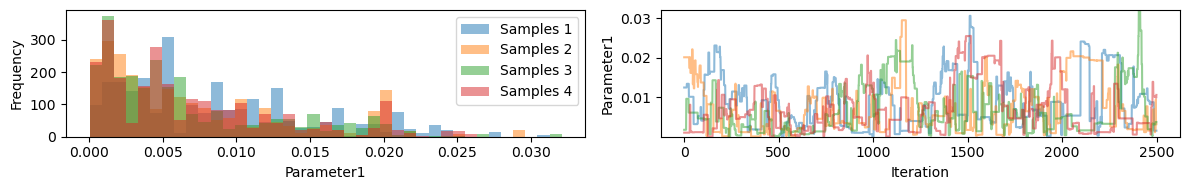

In [28]:
s = load_samples('./chains/MCMC_M_org1_samples_idx0.csv')
pints.plot.trace(s.reshape(4,2500,1))

(<Figure size 1200x1200 with 12 Axes>,
 array([[<Axes: xlabel='Parameter1', ylabel='Frequency'>,
         <Axes: xlabel='Iteration', ylabel='Parameter1'>],
        [<Axes: xlabel='Parameter2', ylabel='Frequency'>,
         <Axes: xlabel='Iteration', ylabel='Parameter2'>],
        [<Axes: xlabel='Parameter3', ylabel='Frequency'>,
         <Axes: xlabel='Iteration', ylabel='Parameter3'>],
        [<Axes: xlabel='Parameter4', ylabel='Frequency'>,
         <Axes: xlabel='Iteration', ylabel='Parameter4'>],
        [<Axes: xlabel='Parameter5', ylabel='Frequency'>,
         <Axes: xlabel='Iteration', ylabel='Parameter5'>],
        [<Axes: xlabel='Parameter6', ylabel='Frequency'>,
         <Axes: xlabel='Iteration', ylabel='Parameter6'>]], dtype=object))

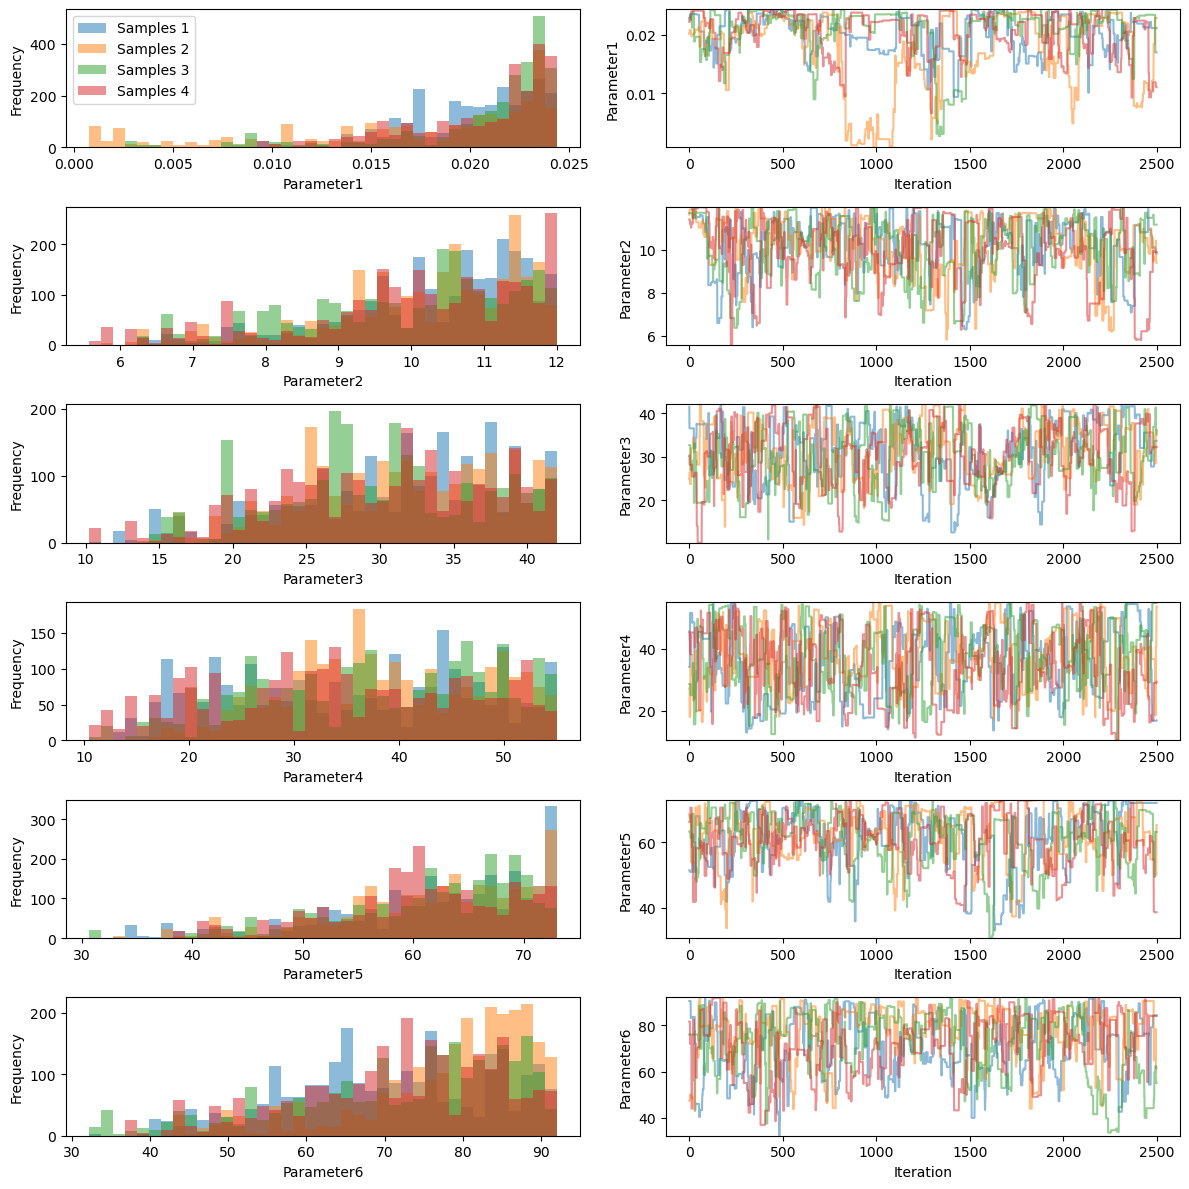

In [29]:
pints.plot.trace(samples[:, warmup:, :])

In [315]:
#check optimization stats:

warmup = 1000 # number of samples to discard as warm up/burn in
m2 = CCNModel(Extra, info_mass, NSD1_vec, NSD2_vec, return_all=True) # Create a new model instance for the posterior analysis
all_output = m2(samples[:, warmup:, 0].mean()) # Call the model with the mean of the samples

print('rhat: ', pints.rhat(samples[:, warmup:, :]), ' (should be close to 1)')
print('effective sample size: ', pints.effective_sample_size(samples[:, warmup:, :].reshape(-1,5)), ' (should be large, > 100)')
print('')
print('optimized M_org1: ', samples[:, warmup:, 0].mean(), ' +/- ', samples[:, warmup:, 0].std())
print('')
print('observed CCN: ', response)
print('optimized CCN: ', m(samples[:, warmup:, 0].mean()))
print('neadler-mean CCN: ', nedmead_results['Predicted_CCN'][2])
print('optimized f_org1: ', all_output[6][0])
print('nedler-mean f_org1: ', nedmead_results['f_org1'][2])


rhat:  [1.10285611 1.02406851 1.0141374  1.07325429 1.17843763 1.08660803]  (should be close to 1)
effective sample size:  [3107.252012594906, 3106.938418818291, 3106.8672231185283, 3107.205018625763, 3107.7346515170425]  (should be large, > 100)

optimized M_org1:  0.02882603523804874  +/-  0.000866070696043562

observed CCN:  [58.6 169.96 210.44 148.36 212.01]
optimized CCN:  [135.33788658 208.44843907 230.77678612 257.29533109 300.11001963]
neadler-mean CCN:  [135.32896002 208.15472166 230.35706304 256.14713121 297.29800116]
optimized f_org1:  0.9253583007687183
nedler-mean f_org1:  0.9559827374289752


In [314]:
all_output[6][0]

0.9253583007687183

(<Figure size 600x200 with 1 Axes>,
 array([<Axes: xlabel='Lag', ylabel='Autocorrelation'>], dtype=object))

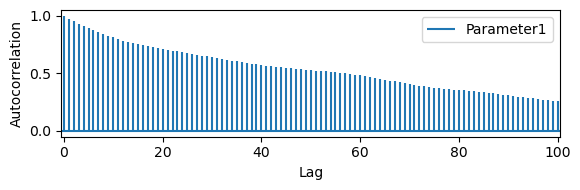

In [301]:
pints.plot.autocorrelation(samples[:, warmup:, 0].reshape(-1,1))

In [229]:
nedmead_results[1:12]

,Unnamed: 0,datetime,NRMSE,predicted_CCN1,predicted_CCN2,inorg_density,Predicted_CCN,f_org1,f_AS1,f_BC1,f_org2,f_AS2,f_BC2,k1,k2,mass_aitken,mass_accumulation
1,1,2016-08-16 11:00:00,0.079368,[ 5.9238086 20.64051432 38.26492389 69.215849...,[104.50857129 165.20025268 185.27327315 199.70...,1766.689957,[110.43237989 185.84076701 223.53819704 268.92...,0.000241,0.969959,0.029800,0.636371,0.333830,0.029800,0.595034,0.264777,0.056602,1.845879
2,2,2016-08-16 13:00:00,0.456524,[ 0.21076595 2.26276781 5.16077737 12.976363...,[135.11819407 205.89195385 225.19628567 243.17...,1768.244800,[135.32896002 208.15472166 230.35706304 256.14...,0.955983,0.000261,0.043756,0.589202,0.367042,0.043756,0.115630,0.278570,0.031151,1.982821
3,3,2016-08-16 15:00:00,1.912441,[ 0.26274011 3.49504063 7.42819384 18.796237...,[100.98659544 213.27721373 240.27306711 267.85...,1764.122863,[101.24933555 216.77225436 247.70126095 286.65...,0.942483,0.000067,0.057450,0.777283,0.165267,0.057450,0.114134,0.186080,0.043934,1.933302
4,4,2016-08-17 11:00:00,0.146238,[ 21.70721025 90.84075033 158.7795288 344.25...,[ 94.00714659 189.48019379 211.95790386 230.34...,1765.764017,[115.71435684 280.32094412 370.73743266 574.60...,0.534998,0.416524,0.048477,0.704828,0.246694,0.048477,0.302808,0.223271,0.400352,1.500230
5,5,2016-08-17 13:00:00,0.156377,[ 30.53917199 105.89260508 184.79589279 385.22...,[ 94.87559732 190.14745937 212.11460765 233.94...,1767.174878,[125.41476931 296.04006445 396.91050044 619.17...,0.434428,0.516295,0.049277,0.694329,0.256393,0.049277,0.350751,0.227225,0.433499,1.501279
6,6,2016-08-17 15:00:00,0.097932,[ 0.0756145 1.60487412 5.11061128 16.205469...,[ 91.29303375 334.50161837 481.61393933 671.45...,1762.901380,[ 91.36864825 336.10649249 486.72455061 687.66...,0.947496,0.000027,0.052477,0.723928,0.223595,0.052477,0.114632,0.213129,0.032926,2.009854
7,7,2016-08-17 17:00:00,0.083278,[ 2.13863978 18.04753657 38.01733722 79.83...,[ 87.02801875 318.15707113 456.9922652 608.90...,1763.759503,[ 89.16665853 336.20460769 495.00960242 688.74...,0.811593,0.141877,0.046530,0.740037,0.213433,0.046530,0.176776,0.208845,0.123063,1.916353
8,8,2016-08-17 19:00:00,0.079634,[2.36427287e-03 1.04654097e-01 5.67778610e-01 ...,[ 90.11569179 363.01212109 567.04587231 812.85...,1761.811644,[ 90.11805606 363.11677518 567.61365092 816.26...,0.937458,0.000893,0.061648,0.760568,0.177784,0.061648,0.114053,0.191746,0.010675,2.292290
9,9,2016-08-17 21:00:00,0.126446,[2.06191423e-02 6.23970227e-01 2.66586766e+00 ...,[ 96.48787008 374.8154837 574.00419242 816.48...,1762.176929,[ 96.50848922 375.43945393 576.67006008 82...,0.936497,0.000462,0.063041,0.762203,0.174756,0.063041,0.113724,0.190178,0.026063,2.502036
10,10,2016-08-17 23:00:00,0.154749,[4.20608002e-02 1.38166142e+00 6.26035249e+00 ...,[108.66250744 402.3734088 606.82259771 826.59...,1762.006278,[ 108.70456824 403.75507022 613.0829502 85...,0.944603,0.000182,0.055216,0.761639,0.183145,0.055216,0.114415,0.194730,0.061644,2.693935


In [ ]:
m2=CCNModel(Extra, info_mass, NSD1_vec, NSD2_vec,return_all=True) #if I want to return all, I need to make another instance of the model. I could then calculate all the extras in a loop without the optimizatin for example.

In [159]:
m2(0.006)

(array([  4.38503997,  18.55026749,  34.03250885,  68.44991788,
        107.70411196]),
 array([ 77.88492821, 121.61703999, 136.41742192, 146.31669737,
        150.43457464]),
 0.5328962716592692,
 0.2897048194129155,
 0.6119780786459629,
 0.6119780786459629,
 [0.11412566709000693, 1, 0.8621377260749163, 0, 0.023736606835076796],
 [0.589219609665178, 1, 0.3870437834997454, 0, 0.023736606835076803],
 0.052573624785632225,
 1.5982874334212336)

In [ ]:
print('M_org1 mean:', samples[:, 1000:, 0].mean())
print('M_org1 std:', samples[:, 1000:, 0].std())

print()

M_org1 mean: 0.006471674030135184
M_org1 std: 0.006293224110615699


In [25]:
m.kappas

[array([0.5815618]),
 array([0.28836181]),
 0.6119780786459629,
 0.6119780786459629]

In [28]:
m.CCNs

[array([  4.81565423,  19.68537412,  37.21750284,  71.38989379,
        109.40987536]),
 array([ 77.72048064, 121.50023319, 136.35609329, 146.28736078,
        150.43138357])]

In [37]:
print(m.CCNs[0]+m.CCNs[1])
print(response)
print(nedmead_results['Predicted_CCN'][0])

[ 82.53613487 141.1856073  173.57359613 217.67725456 259.84125892]
[102.75 182.79 248.7 249.63 250.62]
[ 82.63042095 141.49618239 174.54355345 218.58103063 260.36721824]


In [77]:
m(samples[:, 2000:, 0].mean())

array([ 82.2468067 , 140.07600666, 170.28743206, 214.50182721,
       257.94956909])

In [74]:
m(samples[3, -1, 0])

array([ 82.53613487, 141.1856073 , 173.57359613, 217.67725456,
       259.84125892])

In [ ]:
# 7. Run the sampler
samples = mcmc.run()

In [ ]:
# Check convergence and other properties of chains
results = pints.MCMCSummary(chains=samples[:, 1000:, :], time=mcmc.time(), parameter_names=['M_org1', 'sigma1', 'sigma2', 'sigma3', 'sigma4', 'sigma5'])
print(results)

param    mean    std.    2.5%    25%    50%    75%    97.5%    rhat    ess    ess per sec.
-------  ------  ------  ------  -----  -----  -----  -------  ------  -----  --------------
M_org1   0.02    0.00    0.01    0.02   0.02   0.02   0.02     1.02    71.42  0.12
sigma1   26.61   6.12    14.14   22.19  27.12  31.66  36.80    1.16    58.56  0.10
sigma2   28.31   5.26    18.71   24.87  28.21  31.73  38.24    1.19    50.60  0.08
sigma3   36.76   2.17    31.72   35.57  37.08  38.44  39.80    1.01    71.38  0.12
sigma4   33.00   4.32    23.71   30.74  33.35  36.42  39.44    1.12    88.37  0.15
sigma5   9.69    10.09   0.54    2.35   5.67   13.47  37.50    1.21    56.18  0.09


In [ ]:
samples[:, 1000:, 0].mean()

0.01675715722752075

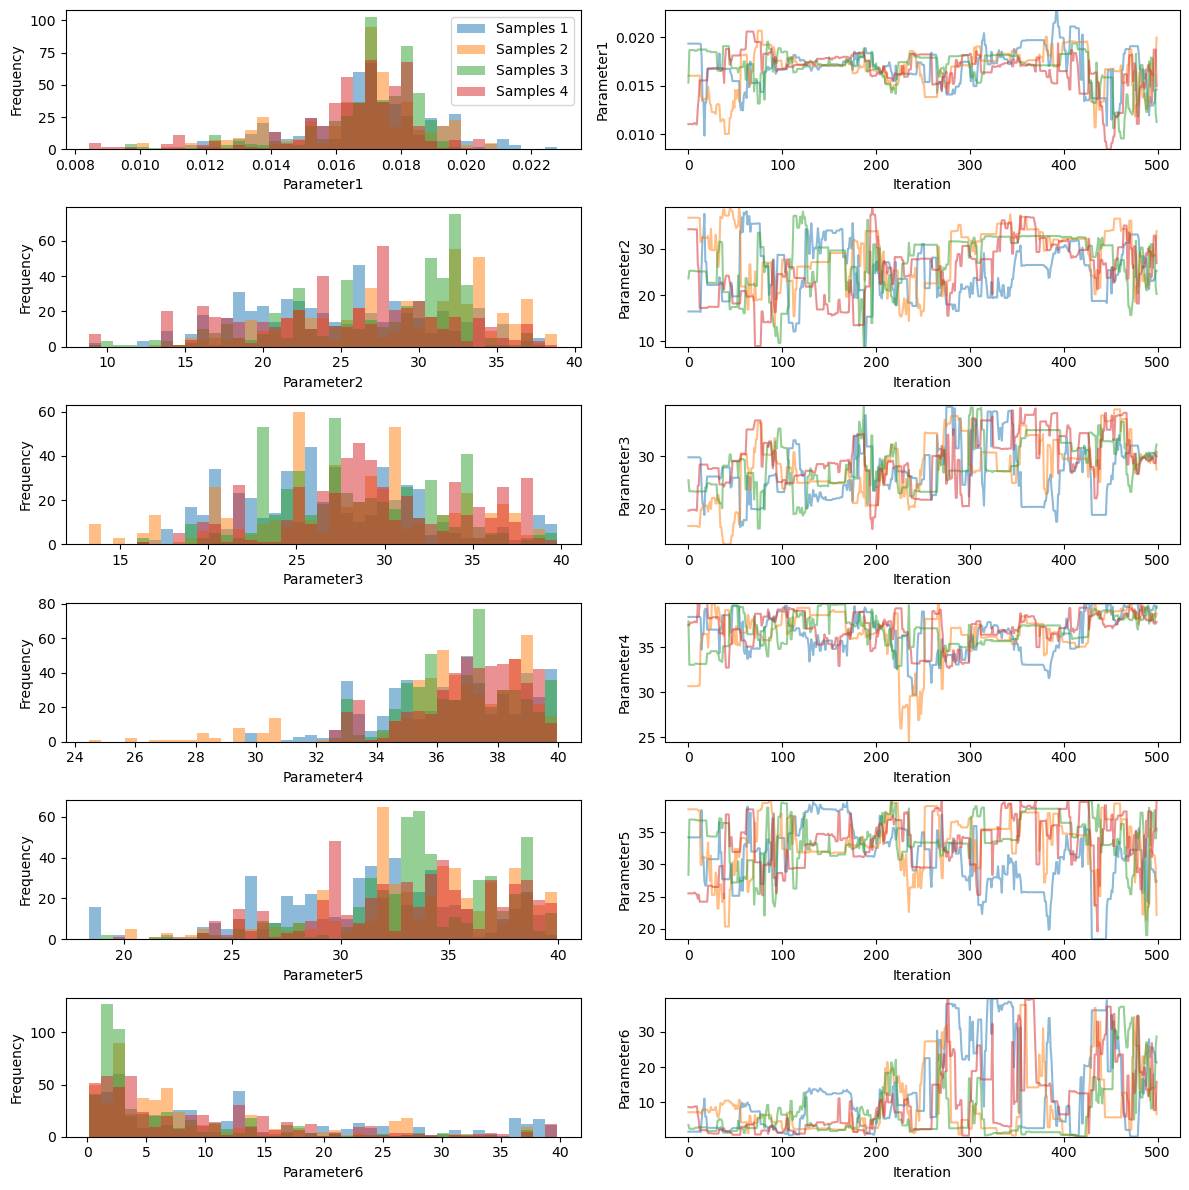

In [ ]:
# 8. Show results
import pints.plot
# Discard warm up
chains = samples[:, 1000:, :]

pints.plot.trace(chains)
plt.show()

Sudo-code framework for dream-mcmc with PINTS:

1. define model (to calculate CCN, given optimizing parameters)

2. get CCN observed time-series

3. define problem (links model and time series)

4. setup MCMC
    - likelihood
    - priors over parameters
    - create posterior

5. define MCMC controller

In [ ]:
# Load observed data from CSV files

obs_dir = 'input_data'                    

nsd_abs1 = pd.read_csv(os.path.join(obs_dir, 'NSD_mode1.csv'))  # Load NSD data for mode 1
nsd_abs2 = pd.read_csv(os.path.join(obs_dir, 'NSD_mode2.csv'))  # Load NSD data for mode 2
comp_obs = pd.read_csv(os.path.join(obs_dir, 'comp.csv'))  # Load observed composition data, mass fractions/concentrations
ccn_obs = pd.read_csv(os.path.join(obs_dir, 'CCN.csv'))  # Load observed CCN data
dp_dry = np.loadtxt('Dp.txt')  # Dry particle diameters in nanometers

if not all(len(df) == len(nsd_abs1) for df in [nsd_abs2, comp_obs, ccn_obs]):
    raise ValueError('Dataframes have different lengths')

In [ ]:
# MAKE "EXTRA" parameter dictionary

sigma_ls = [72.8, 30, 35, 40, 45, 50, 60, 70] #in mN/m, surface tension

# ------ create "Extra" dictionary to store additional parameters:
Extra = dict()

#'densities sequence: Organics, Ammonium Sulphate, Ammonium Nitrate, Black Carbon '
Extra['densities'] = [1.50*1e3, 1.77*1e3, 1.71*1e3, 1.77*1e3]# %cross et al. 2015, %Park et al.,2004

rho_org = Extra['densities'][0]
rho_sulp = Extra['densities'][1]   # in kg/m^3
rho_nitr = Extra['densities'][2]
rho_bc = Extra['densities'][3]

Extra['kappa_org'] = 0.1  # Kappa value (hygroscopicity parameter) for organic compounds
Extra['kappa_NH4SO4'] = 0.61  # Kappa value (hygroscopicity parameter) for ammonium sulfate (NH4)2SO4
Extra['kappa_NH4NO3'] = 0.67  # Kappa value (hygroscopicity parameter) for ammonium nitrate NH4NO3
Extra['eBC'] = 0  # Kappa value (hygroscopicity parameter) for black carbon

Extra['sigma'] = sigma_ls[0] * 1e-3  # Surface tension value in N/m, converted from the given sigma list in milli-Newtons/meter
Extra['ss_amb'] = [0.1, 0.2, 0.3, 0.5, 1.0]  # Ambient supersaturation values as in the CCN counter (in percentage), CCN calculations
Extra['wet_dia'] = np.logspace(0, 4.35, 200)  # Wet diameter of particles in nanometers, logarithmically spaced between 1 nm and 10^4.35 nm over 200 points
Extra['temp'] = 298.48  # Median temperature in Kelvin, the hut median temperature over the entire timeseries (approximately 25.33°C)

# THIS IS A GUESS, NEED TO CHECK WITH RAHUL THAT THIS IS THE CORRECT DATA!!
# Get dry particle diameters: 
dp_dry = np.loadtxt('Dp.txt')  # Dry particle diameters in nanometers
Extra['dp'] = dp_dry

# Calculate the initial upper and lower boundaries for the first dry particle diameter (dp_dry)
d_upper0 = dp_dry[0] + (dp_dry[1] - dp_dry[0]) / 2  # Upper boundary for the first bin
d_lower0 = dp_dry[0] - (dp_dry[1] - dp_dry[0]) / 2  # Lower boundary for the first bin

# Initialize arrays to store the lower and upper boundaries of all dry particle diameters
# Using np.full_like to create arrays of the same shape as dp_dry, filled with the initial lower/upper values
d_lower_arr_vec = np.full_like(dp_dry, d_lower0)  # Array for lower boundaries, starting with d_lower0
d_upper_arr_vec = np.full_like(dp_dry, d_upper0)  # Array for upper boundaries, starting with d_upper0

# Populate the arrays with the upper and lower diameter boundaries for each particle size
for i in range(1, len(dp_dry)):
    d_lower_arr_vec[i] = d_upper_arr_vec[i - 1]  # Lower boundary for the current bin equals the upper boundary of the previous bin
    d_upper_arr_vec[i] = dp_dry[i] + dp_dry[i] - d_lower_arr_vec[i]  # Upper boundary calculated based on particle diameter and lower boundary

# Store the lower and upper boundary arrays in the 'Extra' dictionary for later use
Extra['d_lower_arr'] = d_lower_arr_vec  # Lower boundary array
Extra['d_upper_arr'] = d_upper_arr_vec  # Upper boundary array

# Extra['true_inputs'] are the observerd mass fractions.
Extra['true_inputs'] = [
    comp_obs['Org'],
    comp_obs['total_mass'],
    comp_obs['NH4SO4'],
    comp_obs['NH4NO3'],
    comp_obs['eBC880']
    ] # [Org, Other, NH4SO4, NH4NO3, BC] (n_times=6580, n_fracs=5)

#------------------

# observed number size distributions:
NSD1_vec = np.array(nsd_abs1.iloc[0,1:].values)
NSD2_vec = np.array(nsd_abs2.iloc[0,1:].values)

response = np.array(ccn_obs.iloc[0,1:].values)

# Extra['true_inputs'] are the observerd mass fractions.
Extra['true_inputs'] = [
    comp_obs['Org'][0],
    comp_obs['total_mass'][0],
    comp_obs['NH4SO4'][0],
    comp_obs['NH4NO3'][0],
    comp_obs['eBC880'][0]
    ] # [Org, Other, NH4SO4, NH4NO3, BC]


# mass of ammonium sulfate and nitrate
mass_vec_NH4SO4 = comp_obs['NH4SO4'][0] * comp_obs['total_mass'][0]
mass_vec_NH4NO3 = comp_obs['NH4NO3'][0] * comp_obs['total_mass'][0]

# mass fractions
mass_frac_vec_NH4SO4 = mass_vec_NH4SO4 / (mass_vec_NH4SO4 + mass_vec_NH4NO3)
mass_frac_vec_NH4NO3 = mass_vec_NH4NO3 / (mass_vec_NH4SO4 + mass_vec_NH4NO3)

# get inorganic density (we include both NH4SO4 and NH4NO3)
Extra['rho_inorg'] = (mass_frac_vec_NH4SO4 * rho_sulp) + (mass_frac_vec_NH4NO3 * rho_nitr)


In [ ]:

    total_ait_mass = M_org1 + M_AS1 + initial_M_BC1
    total_acc_mass = M_org2 + M_AS2 + initial_M_BC2

    # Ensure masses are non-negative and within tolerance
    #if (
    #    (0.99999 * initial_tot_ait_mass < total_ait_mass < 1.00001 * initial_tot_ait_mass) and
    #    (0.99999 * initial_tot_acc_mass < total_acc_mass < 1.00001 * initial_tot_acc_mass) and
    #    M_org2 >= 0 and M_AS2 >= 0 and M_AS1 >= 0 and M_org1 >= 0
    #):
    # Use the condition in place of the if-statement


In [ ]:
# pints wrapper onto CCN model

class CCNModel(pints.ForwardModel):
    # might be interesting to change this to pints.ForwardModelS1 (with gradients, but then we will need to use HMC or something that can use gradients)

    #def __init__(self):
        # not sure this is needed

    def n_parameters(self):
        #number of parameters (currently only optimizing organic mass fraction)
        return 1
    
    def n_outputs(self):
        #number of outputs (currently outputting CCN for 5 supersaturations)
        return 5
    
    def simulate(self, parameters, times):
        # Run a simulation with the given parameters, log all the results
        # returns CCN array of size (n_times, 5) for 5 supersaturations

        # observed number size distributions:
        NSD1_vec = np.array(nsd_abs1.iloc[0,1:].values)
        NSD2_vec = np.array(nsd_abs2.iloc[0,1:].values)

        response = np.array(ccn_obs.iloc[0,1:].values)

        # Extra['true_inputs'] are the observerd mass fractions.
        Extra['true_inputs'] = [
            comp_obs['Org'][0],
            comp_obs['total_mass'][0],
            comp_obs['NH4SO4'][0],
            comp_obs['NH4NO3'][0],
            comp_obs['eBC880'][0]
            ] # [Org, Other, NH4SO4, NH4NO3, BC]


        # mass of ammonium sulfate and nitrate
        mass_vec_NH4SO4 = comp_obs['NH4SO4'][0] * comp_obs['total_mass'][0]
        mass_vec_NH4NO3 = comp_obs['NH4NO3'][0] * comp_obs['total_mass'][0]

        # mass fractions
        mass_frac_vec_NH4SO4 = mass_vec_NH4SO4 / (mass_vec_NH4SO4 + mass_vec_NH4NO3)
        mass_frac_vec_NH4NO3 = mass_vec_NH4NO3 / (mass_vec_NH4SO4 + mass_vec_NH4NO3)

        # get inorganic density (we include both NH4SO4 and NH4NO3)
        Extra['rho_inorg'] = (mass_frac_vec_NH4SO4 * rho_sulp) + (mass_frac_vec_NH4NO3 * rho_nitr)

        # calculate mass of organics, inorganics and BC:
        info_mass = cal_mass(dp_dry, Extra['true_inputs'], Extra, NSD1_vec, NSD2_vec)

        # get mass fractions of organics and inorganics
        mass_frac_aitken, mass_frac_accumulation = get_mass_fracs(info_mass, parameters)

        # calculate CCN:
        ccn1, k1, k_inorg = execute_test_run(mass_frac_aitken, Extra, NSD1_vec)
        ccn2, k2, k_inorg2 = execute_test_run(mass_frac_accumulation, Extra, NSD2_vec)
     
        return ccn1 + ccn2
        

In [ ]:
#setup DreamMCMC

# instance of the model
model = CCNModel()

# get times and values from observations
time_vec = np.array([0])
obs = np.array(ccn_obs.iloc[0,1:].values)
obs = np.reshape(obs, (1,5))

# Create an object with links to the model and time series
problem = pints.MultiOutputProblem(model, time_vec, obs)

# Create a log-likelihood function (adds an extra parameter for each output)
log_likelihood = pints.GaussianLogLikelihood(problem)

# Create a uniform prior over both the parameter and the noise for each output
log_prior = pints.UniformLogPrior(
    [0,0,0,0,0,0],
    [0.5,50,50,50,50,50]
    )

# Create a posterior log-likelihood
log_posterior = pints.LogPosterior(log_likelihood, log_prior)

# set initial parameter values for M_org1 and noise (one for each chain)
initial_parameters = np.concatenate([np.array([0.03]), np.array(ccn_obs.iloc[0,1:].values)*0.1])
x0 = [
    initial_parameters * 0.5,
    initial_parameters * 1.1,
    initial_parameters * 1.5
    ]

# setup optimisation controller
mcmc = pints.MCMCController(log_posterior, 3, x0, method=pints.DreamMCMC) # inputs: log_pdf, number of MCMC chains, initial points, method (optional = initial covariance matrix, paramater transformation)
mcmc.set_initial_phase_iterations(500)
mcmc.set_max_iterations(3000)
mcmc.set_log_to_screen(False)

C:\Users\made2928\AppData\Local\Temp\ipykernel_19184\3017956309.py:18: DeprecationWarning: `product` is deprecated as of NumPy 1.25.0, and will be removed in NumPy 2.0. Please use `prod` instead.
  log_prior = pints.UniformLogPrior(


In [ ]:
model.simulate(0.03, 0)

array([ 79.1140827 , 131.44644512, 157.72343158, 193.88377329,
       243.63465402])

In [ ]:
chains = mcmc.run()

In [ ]:
chains.shape

(3, 3000, 6)

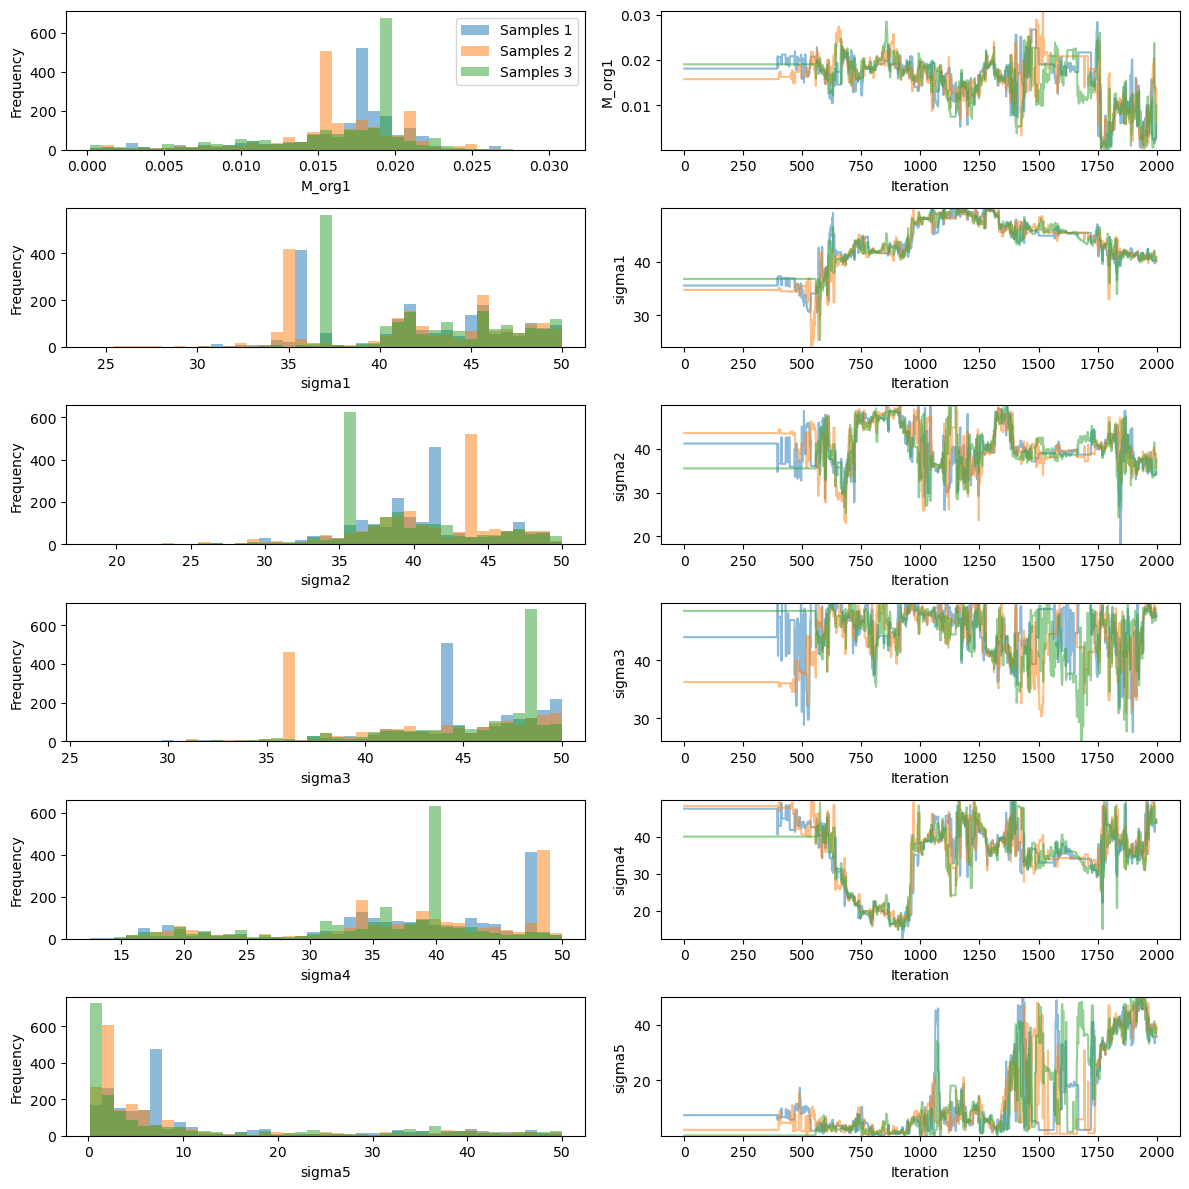

In [ ]:
pints.plot.trace(chains[:, 1000:], parameter_names=['M_org1','sigma1','sigma2','sigma3','sigma4','sigma5'])
plt.show()

In [ ]:
chains[0].shape

(3000, 6)

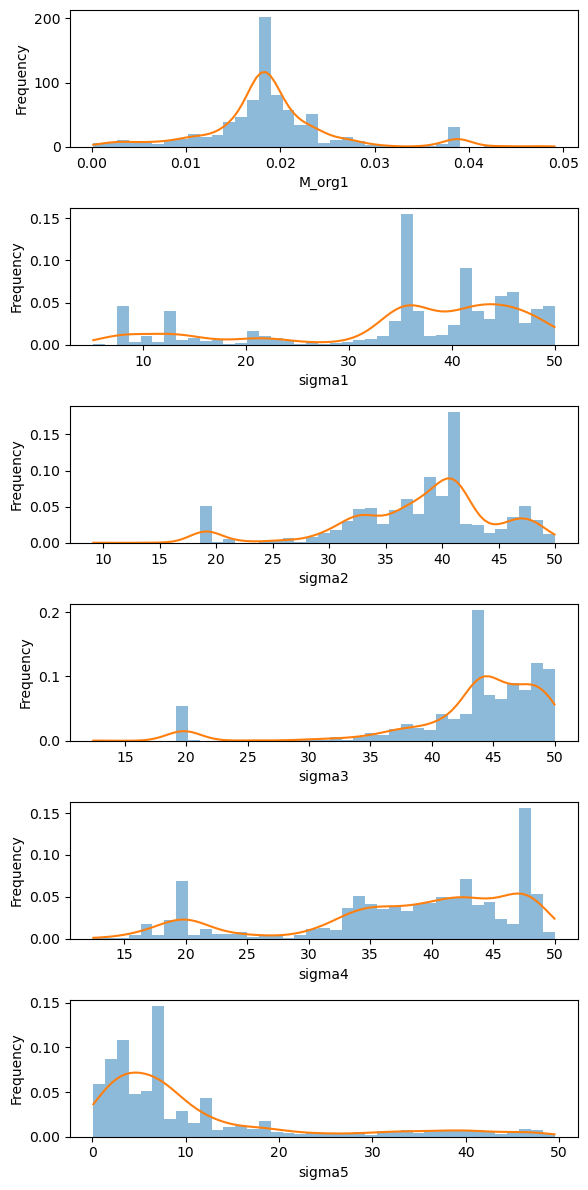

In [ ]:
pints.plot.histogram([chains[0]], kde=True, parameter_names=['M_org1','sigma1','sigma2','sigma3','sigma4','sigma5'])
plt.show()

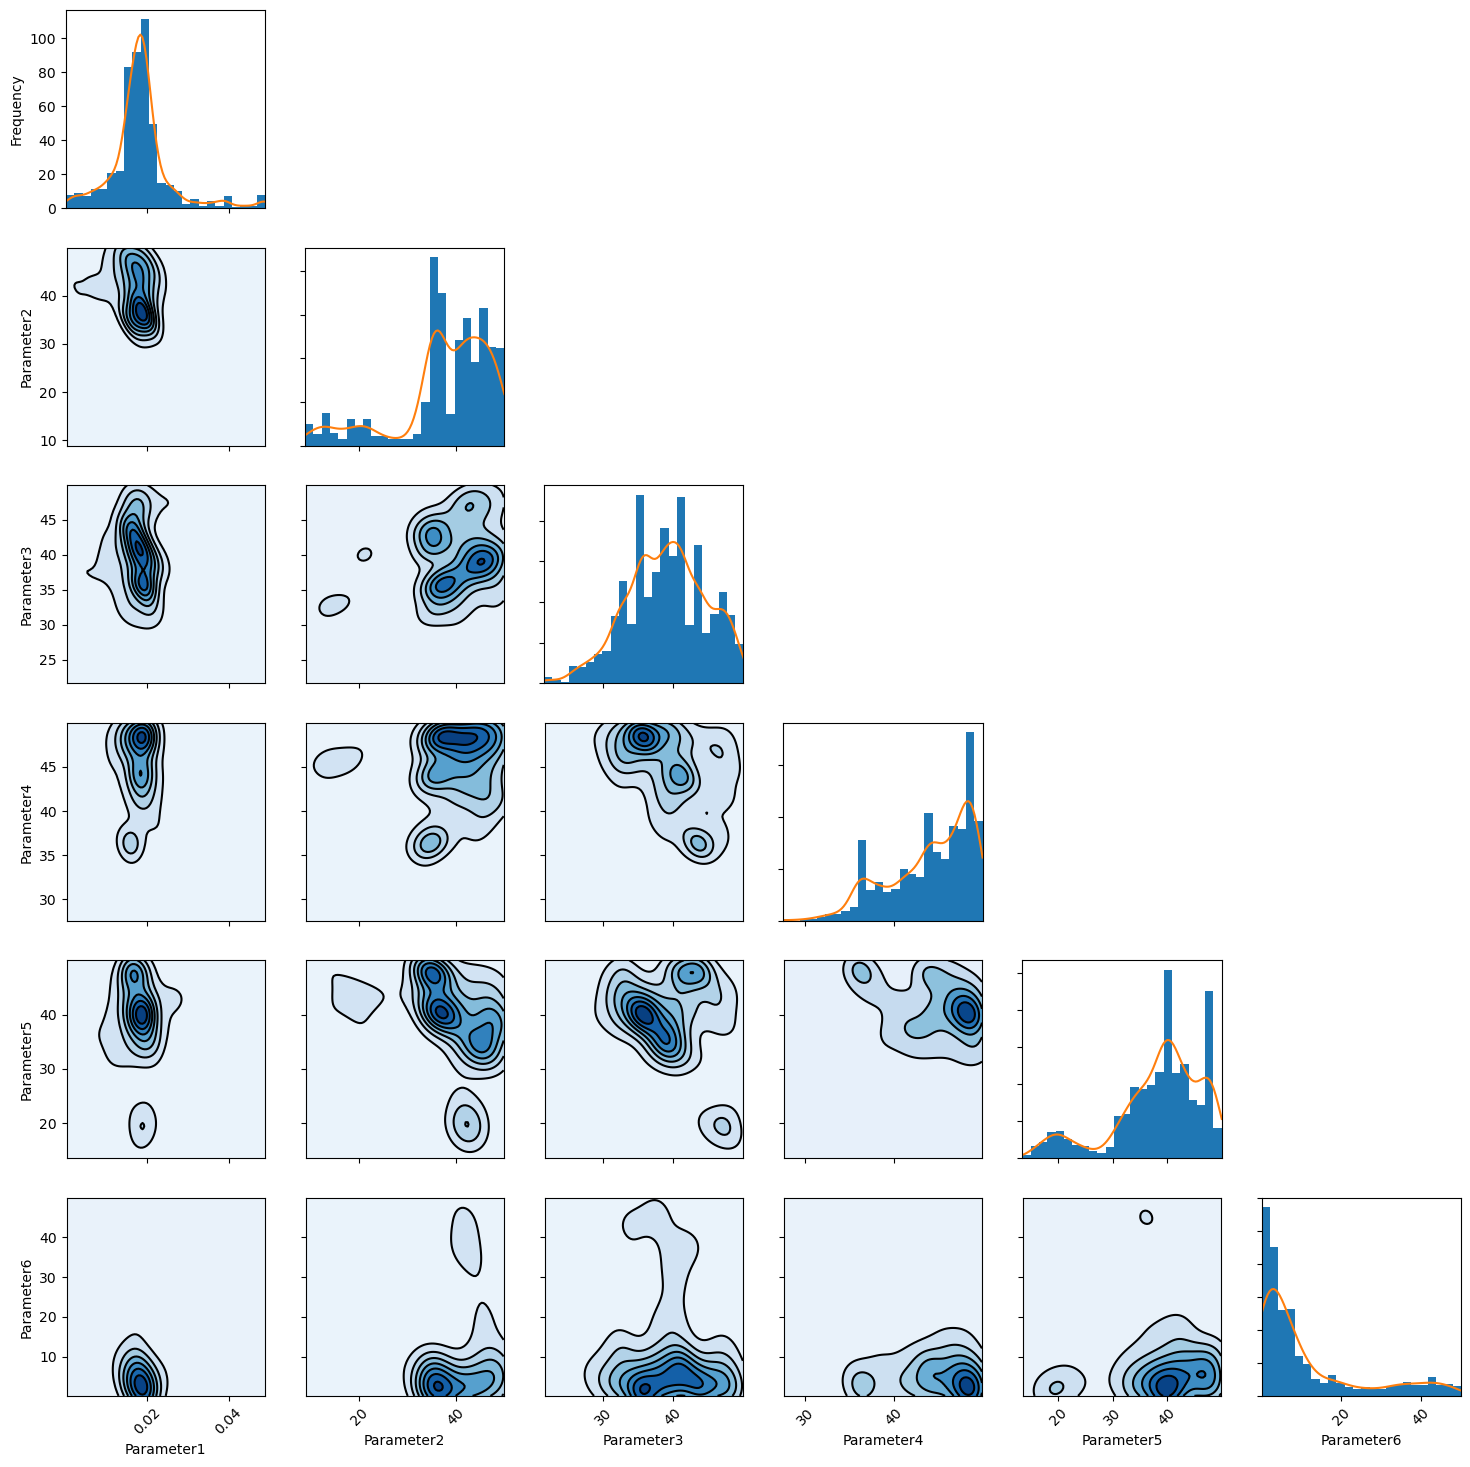

In [ ]:
# Plot output
stacked = np.vstack(chains[:, 200::5])
pints.plot.pairwise(stacked, kde=True)
plt.show()

In [ ]:
results = pints.MCMCSummary(chains=chains[:, 500:], time=mcmc.time(), parameter_names=['frac_org1', 'sigma1', 'sigma2', 'sigma3', 'sigma4', 'sigma5'])
print(results)

param      mean    std.    2.5%    25%    50%    75%    97.5%    rhat    ess    ess per sec.
---------  ------  ------  ------  -----  -----  -----  -------  ------  -----  --------------
frac_org1  0.02    0.00    0.00    0.02   0.02   0.02   0.02     1.06    56.50  0.09
sigma1     40.27   6.42    21.26   35.83  41.22  45.40  49.63    1.59    13.24  0.02
sigma2     39.49   4.98    29.87   35.54  39.55  43.51  48.65    1.08    61.99  0.10
sigma3     44.48   4.57    34.59   41.76  45.65  48.55  49.89    1.13    76.66  0.12
sigma4     37.94   8.35    17.66   34.24  39.99  43.82  48.26    1.12    30.53  0.05
sigma5     10.25   12.90   0.24    2.10   4.91   11.46  45.72    1.13    22.45  0.03


In [ ]:
mass_frac_aitken, mass_frac_accumulation = get_mass_fracs(info_mass, 0.01)

        # calculate CCN:
ccn1, k1, k_inorg = execute_test_run(mass_frac_aitken, Extra, NSD1_vec)
ccn2, k2, k_inorg2 = execute_test_run(mass_frac_accumulation, Extra, NSD2_vec)

print(ccn1 + ccn2)

[ 80.35702886 138.02036274 168.06854011 211.5430588  256.07972545]


In [ ]:
response

array([102.75, 182.79, 248.7, 249.63, 250.62], dtype=object)

In [ ]:

# THIS WILL EVENTUALLY BE A TIME SERIES; HERE WE JUST TAKE THE FIRST TIME STEP (ROW) - everywhere there is 0, there could be time index i

NSD1_vec = np.array(nsd_abs1.iloc[0,1:].values)
NSD2_vec = np.array(nsd_abs2.iloc[0,1:].values)

response = np.array(ccn_obs.iloc[0,1:].values)

# Extra['true_inputs'] are the observerd mass fractions.
Extra['true_inputs'] = [
    comp_obs['Org'][0],
    comp_obs['total_mass'][0],
    comp_obs['NH4SO4'][0],
    comp_obs['NH4NO3'][0],
    comp_obs['eBC880'][0]
    ] # [Org, Other, NH4SO4, NH4NO3, BC]


# mass of ammonium sulfate and nitrate
mass_vec_NH4SO4 = comp_obs['NH4SO4'][0] * comp_obs['total_mass'][0]
mass_vec_NH4NO3 = comp_obs['NH4NO3'][0] * comp_obs['total_mass'][0]

# mass fractions
mass_frac_vec_NH4SO4 = mass_vec_NH4SO4 / (mass_vec_NH4SO4 + mass_vec_NH4NO3)
mass_frac_vec_NH4NO3 = mass_vec_NH4NO3 / (mass_vec_NH4SO4 + mass_vec_NH4NO3)

# get inorganic density (we include both NH4SO4 and NH4NO3)
Extra['rho_inorg'] = (mass_frac_vec_NH4SO4 * rho_sulp) + (mass_frac_vec_NH4NO3 * rho_nitr)

# calculate mass of organics, inorganics and BC:
info_mass = cal_mass(dp_dry, Extra['true_inputs'], Extra, NSD1_vec, NSD2_vec)

def get_mass_fracs(info_mass, M_org1):

    # Initial values for mass fractions in Aitken and Accumulation modes
    initial_M_BC1 = info_mass['M_BC1']  # Black carbon in Aitken mode
    initial_M_BC2 = info_mass['M_BC2']  # Black carbon in Accumulation mode
    initial_M_org1 = info_mass['M_org1']  # Organics in Aitken mode
    initial_M_org2 = info_mass['M_org2']  # Organics in Accumulation mode
    initial_M_AS1 = info_mass['M_AS1']  # Ammonium sulfate in Aitken mode
    initial_M_AS2 = info_mass['M_AS2']  # Ammonium sulfate in Accumulation mode
    initial_M_AN1 = info_mass['M_AN1']  # Ammonium nitrate in Aitken mode
    initial_M_AN2 = info_mass['M_AN2']  # Ammonium nitrate in Accumulation mode
    tot_mass_org = info_mass['tot_org']
    tot_mass_AS = info_mass['tot_AS'] + info_mass['tot_AN']  # Total ammonium salts (sulfate + nitrate)
    initial_tot_acc_mass = info_mass['tot_mass_mode2']  # Total mass in Accumulation mode
    initial_tot_ait_mass = info_mass['tot_mass_mode1']  # Total mass in Aitken mode
    initial_tot_mass = initial_tot_ait_mass + initial_tot_acc_mass

    # Mass fractions for black carbon
    f_BC1 = initial_M_BC1 / initial_tot_ait_mass
    f_BC2 = initial_M_BC2 / initial_tot_acc_mass

    # use M_org1_samples to store the initial mass of organics in mode 1 (this is what we are optimizing later!)
    #M_org1_samples = initial_M_org1
    #M_org1 = initial_M_org1

    # Calculate remaining mass in each mode
    M_AS1 = initial_tot_ait_mass - (M_org1 + initial_M_BC1) # inorganics mass in mode1
    M_org2 = tot_mass_org - M_org1 #organics mass in mode2
    M_AS2 = tot_mass_AS - M_AS1 #inorganics mass in mode2
    total_ait_mass = M_org1 + M_AS1 + initial_M_BC1
    total_acc_mass = M_org2 + M_AS2 + initial_M_BC2

    # Ensure masses are non-negative and within tolerance
    if (
        (0.99999 * initial_tot_ait_mass < total_ait_mass < 1.00001 * initial_tot_ait_mass) and
        (0.99999 * initial_tot_acc_mass < total_acc_mass < 1.00001 * initial_tot_acc_mass) and
        M_org2 >= 0 and M_AS2 >= 0 and M_AS1 >= 0 and M_org1 >= 0
    ):
        # Use the condition in place of the if-statement
        f_org1 = M_org1 / total_ait_mass
        f_AS1 = M_AS1 / total_ait_mass
        f_org2 = M_org2 / total_acc_mass
        f_AS2 = M_AS2 / total_acc_mass

        tot_frac1_vec, tot_frac2_vec = f_org1 + f_AS1 + f_BC1, f_org2 + f_AS2 + f_BC2
        
        mass_frac_aitken = [f_org1, tot_frac1_vec, f_AS1, 0, f_BC1] # sequence is organics, total mass fraction/ inorganics, nitrate, eBC
        mass_frac_accumulation = [f_org2, tot_frac2_vec, f_AS2, 0, f_BC2]

        return mass_frac_aitken, mass_frac_accumulation

    else:
        print('Mass fractions not within tolerance.')


#predict CCN at 5 different supersaturations:

ccn1, k1, k_inorg = execute_test_run(mass_frac_aitken, Extra, NSD1_vec)
ccn2, k2, k_inorg2 = execute_test_run(mass_frac_accumulation, Extra, NSD2_vec)
ccn_total = ccn1 + ccn2




In [ ]:
ccn_total

array([ 79.10819965, 131.39608534, 157.60222556, 193.67122313,
       243.48942128])

In [ ]:
response

array([102.75, 182.79, 248.7, 249.63, 250.62], dtype=object)

In [ ]:
ccn_obs

,datetime,SC1,SC2,SC3,SC4,SC5
0,2016-08-16 09:00:00,102.75,182.79,248.70,249.63,250.62
1,2016-08-16 11:00:00,112.11,212.34,239.46,263.94,323.40
2,2016-08-16 13:00:00,58.60,169.96,210.44,148.36,212.01
3,2016-08-16 15:00:00,32.89,80.87,104.85,111.25,101.16
4,2016-08-17 11:00:00,122.56,363.89,438.07,569.09,716.93
...,...,...,...,...,...,...
6575,2020-04-01 11:00:00,16.78,35.98,54.32,65.35,73.87
6576,2020-04-01 15:00:00,19.99,64.06,82.22,87.80,108.01
6577,2020-04-01 17:00:00,17.06,71.94,94.67,108.03,216.22
6578,2020-04-01 19:00:00,22.30,69.23,99.97,122.10,171.47


In [ ]:

# Calculate mass concentrations (pars into execute_test_run)

#info_mass = cal_mass(dp_dry, Extra['true_inputs'], Extra, NSD1_vec, NSD2_vec)
info_mass = cal_mass(dp_dry, Extra['true_inputs'], Extra, nsd_vec1, nsd_vec2)

# Initial values for mass fractions in Aitken and Accumulation modes
initial_M_BC1 = info_mass['M_BC1']  # Black carbon in Aitken mode
initial_M_BC2 = info_mass['M_BC2']  # Black carbon in Accumulation mode
initial_M_org1 = info_mass['M_org1']  # Organics in Aitken mode
initial_M_org2 = info_mass['M_org2']  # Organics in Accumulation mode
initial_M_AS1 = info_mass['M_AS1']  # Ammonium sulfate in Aitken mode
initial_M_AS2 = info_mass['M_AS2']  # Ammonium sulfate in Accumulation mode
initial_M_AN1 = info_mass['M_AN1']  # Ammonium nitrate in Aitken mode
initial_M_AN2 = info_mass['M_AN2']  # Ammonium nitrate in Accumulation mode
tot_mass_org = info_mass['tot_org']
tot_mass_AS = info_mass['tot_AS'] + info_mass['tot_AN']  # Total ammonium salts (sulfate + nitrate)
initial_tot_acc_mass = info_mass['tot_mass_mode2']  # Total mass in Accumulation mode
initial_tot_ait_mass = info_mass['tot_mass_mode1']  # Total mass in Aitken mode
initial_tot_mass = initial_tot_ait_mass + initial_tot_acc_mass

# Mass fractions for black carbon
f_BC1 = initial_M_BC1 / initial_tot_ait_mass
f_BC2 = initial_M_BC2 / initial_tot_acc_mass

#mass_frac_ACSM = [tot_mass_org/initial_tot_mass, 1, tot_mass_AS/initial_tot_mass, 0, f_BC1]

#M_org1 = np.random.uniform(low=initial_M_org1*0.001, high=initial_M_org1*1.01, size=10)
#M_org1 = pm.Uniform('M_org1', lower = initial_M_org1*0.001, upper = initial_M_org1*1.01, initval = initial_M_org1)   # Total particle concentration in mode1

# Parameters
#samples =  10 # Number of samples to generate

# Define the range in log-space
#log_lower_bound = np.log10(initial_M_org1) - 3  # Three orders of magnitude lower
#log_upper_bound = np.log10(initial_M_org1) + 0.01  # Slightly above the initial value

# If these are TensorVariables, convert to NumPy scalars
#if isinstance(log_lower_bound, pt.TensorVariable):
#    log_lower_bound = float(log_lower_bound.eval())
#if isinstance(log_upper_bound, pt.TensorVariable):
#log_upper_bound = float(log_upper_bound.eval())

# Generate samples
# TRY WITH ONE GUESS FOR M_ORG1, JUST TO TEST RUNNING EXECUTE_TEST_RUN
#M_org1_samples = np.logspace(log_lower_bound, log_upper_bound, num=samples)
M_org1_samples = initial_M_org1
M_org1 = initial_M_org1

#for i in range(len(M_org1_samples)):
    # Calculate remaining mass in each mode
M_AS1 = initial_tot_ait_mass - (M_org1_samples + initial_M_BC1) # inorganics mass in mode1
M_org2 = tot_mass_org - M_org1_samples #organics mass in mode2
M_AS2 = tot_mass_AS - M_AS1 #inorganics mass in mode2
total_ait_mass = M_org1_samples + M_AS1 + initial_M_BC1
total_acc_mass = M_org2 + M_AS2 + initial_M_BC2

# Ensure masses are non-negative and within tolerance
if (
    (0.99999 * initial_tot_ait_mass < total_ait_mass < 1.00001 * initial_tot_ait_mass) and
    (0.99999 * initial_tot_acc_mass < total_acc_mass < 1.00001 * initial_tot_acc_mass) and
    M_org2 >= 0 and M_AS2 >= 0 and M_AS1 >= 0 and M_org1 >= 0
):
    # Use the condition in place of the if-statement
    f_org1 = M_org1 / total_ait_mass
    f_AS1 = M_AS1 / total_ait_mass
    f_org2 = M_org2 / total_acc_mass
    f_AS2 = M_AS2 / total_acc_mass

    tot_frac1_vec, tot_frac2_vec = f_org1 + f_AS1 + f_BC1, f_org2 + f_AS2 + f_BC2
    
    mass_frac_aitken = [f_org1, tot_frac1_vec, f_AS1, 0, f_BC1] # sequence is organics, total mass fraction/ inorganics, nitrate, eBC
    mass_frac_accumulation = [f_org2, tot_frac2_vec, f_AS2, 0, f_BC2]

else:
    print('Mass fractions not within tolerance.')

Mass fractions not within tolerance.


C:\Users\made2928\AppData\Local\Temp\ipykernel_28480\2139764470.py:22: RuntimeWarning: invalid value encountered in scalar divide
  f_BC1 = initial_M_BC1 / initial_tot_ait_mass


In [ ]:
total_acc_mass

nan

In [ ]:
#predict CCN:

ccn1, dact1, k1, k_inorg = execute_test_run(Extra, nsd_vec1, pars=mass_frac_aitken)
ccn2, dact2, k2, k_inorg2 = execute_test_run(Extra, nsd_vec2, pars=mass_frac_accumulation)
ccn_total = ccn1 + ccn2


NameError: name 'mass_frac_aitken' is not defined

In [ ]:



How to use this function (cal_NSD.py).

N1, D1, GSD1 = params[2], params[0], params[1]

        # Parameters for mode 2 (Accumulation mode)
        N2, D2, GSD2 = params[5], params[3], params[4]

        # Create matrices of modes
        modes = np.array([[N1, GSD1, D1], [N2, GSD2, D2]])
        modes1 = np.array([[N1, GSD1, D1]])
        modes2 = np.array([[N2, GSD2, D2]])

        # Calculate size distributions
        nsd_vec, nsd_abs_vec = CN.size_distribution(modes, Dp)
        nsd_vec1, nsd_abs_vec1 = CN.size_distribution(modes1, Dp)
        nsd_vec2, nsd_abs_vec2 = CN.size_distribution(modes2, Dp)



Steps to calculate CCN spectra while sampling through MCMC

#------------------------ Start: Define Priors --------------------------------#
        errors_NSD = NSD_MAD_harmonized.iloc[i, :]
        #print(errors_NSD) # checked: printing correctly
        median_NSD = NSD_med_harmonized.iloc[i, :]
        #print(median_NSD) # checked: printing correctly

        uncer_N1 = 0.1 * errors_NSD['NSD1_sum']
        uncer_N2 = 0.1 * errors_NSD['NSD2_sum']
        
        # Define a uniform prior distribution for 'N1', the total particle concentration in mode 1.
        N1 = pm.Uniform('N1', lower = errors_NSD['NSD1_sum'] - uncer_N1, upper = errors_NSD['NSD1_sum'] + uncer_N1, 
                                 initval = median_NSD['mode1_n'])   # Total particle concentration in mode1
        #Note: pm.Uniform defines a uniform prior for the parameter N1. A uniform distribution means that 
        # the parameter N1 is equally likely to take any value within the specified range (i.e., between the lower and upper bounds).

        # Define a uniform prior distribution for 'N2', the total particle concentration in mode 1.
        N2 = pm.Uniform('N2', lower = errors_NSD['NSD2_sum'] - uncer_N2, upper = errors_NSD['NSD2_sum'] + uncer_N2, 
                                 initval = median_NSD['mode2_n'])     # Total particle concentration in mode2
        
        uncer_d1 = 0.1 * errors_NSD['mode1_d']
        uncer_d2 = 0.1 * errors_NSD['mode2_d']
        
        d1 = pm.Uniform('d1', errors_NSD['mode1_d'] - uncer_d1, upper = errors_NSD['mode1_d'] - uncer_d1, 
                                 initval = median_NSD['mode1_d'])
        d2 = pm.Uniform('d2', errors_NSD['mode2_d'] - uncer_d2, upper = errors_NSD['mode2_d'] - uncer_d2 , 
                                 initval = median_NSD['mode2_d'])

        uncer_sigma1 = 0.1 * errors_NSD['mode1_sigma']
        uncer_sigma2 = 0.1 * errors_NSD['mode2_sigma']
        sigma1 = pm.Uniform('sigma1', errors_NSD['mode1_sigma'] - uncer_sigma1, upper = errors_NSD['mode1_sigma'] + uncer_sigma1, 
                                     initval = median_NSD['mode1_sigma'])
        sigma2 = pm.Uniform('sigma2', errors_NSD['mode2_sigma'] - uncer_sigma2, upper = errors_NSD['mode2_sigma'] + uncer_sigma2, 
                                     initval = median_NSD['mode2_sigma'])
        
        #Extra['dp'] = pt.as_tensor_variable(Extra['dp'])

        NSD1_vec = make_NSD_pytensor(d1, sigma1, N1, pt.as_tensor_variable(Extra['dp']))
        NSD2_vec = make_NSD_pytensor(d2, sigma2, N2, pt.as_tensor_variable(Extra['dp']))
        print(NSD1_vec) 
        
        # Call function to calculate masses of organics, inorganics, and black carbon
        info_mass = cal_mass_pytensor(dp_dry, Extra['true_inputs'], Extra, NSD1_vec, NSD2_vec)

now sample the mass concentration of chemical species

To sample mass fractions:
        
        # Initial values for mass fractions in Aitken and Accumulation modes
        initial_M_BC1 = info_mass['M_BC1']  # Black carbon in Aitken mode
        initial_M_BC2 = info_mass['M_BC2']  # Black carbon in Accumulation mode
        initial_M_org1 = info_mass['M_org1']  # Organics in Aitken mode
        initial_M_org2 = info_mass['M_org2']  # Organics in Accumulation mode
        initial_M_AS1 = info_mass['M_AS1']  # Ammonium sulfate in Aitken mode
        initial_M_AS2 = info_mass['M_AS2']  # Ammonium sulfate in Accumulation mode
        initial_M_AN1 = info_mass['M_AN1']  # Ammonium nitrate in Aitken mode
        initial_M_AN2 = info_mass['M_AN2']  # Ammonium nitrate in Accumulation mode
        tot_mass_org = info_mass['tot_org']
        tot_mass_AS = info_mass['tot_AS'] + info_mass['tot_AN']  # Total ammonium salts (sulfate + nitrate)
        initial_tot_acc_mass = info_mass['tot_mass_mode2']  # Total mass in Accumulation mode
        initial_tot_ait_mass = info_mass['tot_mass_mode1']  # Total mass in Aitken mode
        initial_tot_mass = initial_tot_ait_mass + initial_tot_acc_mass
        
        # Mass fractions for black carbon
        f_BC1 = initial_M_BC1 / initial_tot_ait_mass
        f_BC2 = initial_M_BC2 / initial_tot_acc_mass
    
        mass_frac_ACSM = [tot_mass_org/initial_tot_mass, 1, tot_mass_AS/initial_tot_mass, 0, f_BC1]
        
        #M_org1 = pm.Uniform('M_org1', lower = initial_M_org1*0.001, upper = initial_M_org1*1.01, initval = initial_M_org1)   # Total particle concentration in mode1
        
        # Parameters
        samples =  required_samples # Number of samples to generate
        
        # Define the range in log-space
        log_lower_bound = np.log10(initial_M_org1) - 3  # Three orders of magnitude lower
        log_upper_bound = np.log10(initial_M_org1) + 0.01  # Slightly above the initial value

        # If these are TensorVariables, convert to NumPy scalars
        if isinstance(log_lower_bound, pt.TensorVariable):
            log_lower_bound = float(log_lower_bound.eval())
        if isinstance(log_upper_bound, pt.TensorVariable):
            log_upper_bound = float(log_upper_bound.eval())
        
        # Generate samples
        M_org1_samples = np.logspace(log_lower_bound, log_upper_bound, num=samples)
        kappa1 = []
        kappa2 = []
        for i in range(len(M_org1_samples)):
            # Calculate remaining mass in each mode
            M_AS1 = initial_tot_ait_mass - (M_org1_samples[i] + initial_M_BC1) # inorganics mass in mode1
            M_org2 = tot_mass_org - M_org1_samples[i] #organics mass in mode2
            M_AS2 = tot_mass_AS - M_AS1 #inorganics mass in mode2
            total_ait_mass = M_org1_samples[i] + M_AS1 + initial_M_BC1
            total_acc_mass = M_org2 + M_AS2 + initial_M_BC2
        
            # Ensure masses are non-negative and within tolerance
            if (
                (0.99999 * initial_tot_ait_mass < total_ait_mass < 1.00001 * initial_tot_ait_mass) and
                (0.99999 * initial_tot_acc_mass < total_acc_mass < 1.00001 * initial_tot_acc_mass) and
                M_org2 >= 0 and M_AS2 >= 0 and M_AS1 >= 0 and M_org1 >= 0
            ):
                # Use the condition in place of the if-statement
                f_org1 = M_org1 / total_ait_mass
                f_AS1 = M_AS1 / total_ait_mass
                f_org2 = M_org2 / total_acc_mass
                f_AS2 = M_AS2 / total_acc_mass
    
                tot_frac1_vec, tot_frac2_vec = f_org1 + f_AS1 + f_BC1, f_org2 + f_AS2 + f_BC2
                
                mass_frac_aitken = [f_org1, tot_frac1_vec, f_AS1, 0, f_BC1] # sequence is organics, total mass fraction/ inorganics, nitrate, eBC
                mass_frac_accumulation = [f_org2, tot_frac2_vec, f_AS2, 0, f_BC2]
        
                kappa1.append(cal_kappa(Extra, mass_frac_aitken))
                kappa2.append(cal_kappa(Extra, mass_frac_accumulation))

        return kappa1, kappa2





from sampled mass concentration you get list of mass fractions in mode1 and mode2 which can be given as an input to 'execute' function that calculates CCN spectra.


In [ ]:
#create forward modeL:

#inputs are number size distribution time-series
#parameters which are constant: "Extra"
#parameters to optimize: "parameters", mass fractions: 
#   p[0] - organic material kappa (k_Org)
#   p[1] - ammonium nitrate kappa (k_N)
#   p[2] - ammonium sulfate kappa (k_s)
#   p[3] - black carbon kappa (k_bc)
#   p[4] - organic material mass fraction (mass[0])
#   p[5] - inorganics mass fraction (mass[2])
#   p[6] - ammonium nitrate mass fraction (mass[3])
#   p[7] - black carbon mass fraction (mass[4])

#output for comparison with observations: CCN spectra

def execute_test_maura(parameters, Extra, NSD):
    """
    Executes a test run to calculate the cloud condensation nuclei (CCN) concentration
    and kappa values based on input parameters.

    Parameters:
    - pars: list or array
        Parameter values for the calculation, which include mass fractions and kappa values.
    - Extra: dict
        Additional parameters such as temperature, surface tension, and particle properties.
    - NSD: numpy array
        Number size distribution for particles.

    Returns (ONLY S; k is a parameter in this version):
    - S: numpy array
        Calculated cloud condensation nuclei (CCN) concentrations.
    - k: float
        Calculated kappa value for the particles.
    - kappa_inorg: float
        Kappa value for inorganic components.
    """
    # Initialize variables to store results
    S = None
    #k = None
    
    # Extract temperature and surface tension from Extra
    T = Extra['temp']        # Temperature in Kelvin
    SIGMA = Extra['sigma']   # Surface tension in N/m
    
    # Call the kappa_kohler_module to calculate CCN, kappa, and inorganic kappa
    ccn, kappa, kappa_inorg = kappa_kohler_module(Extra, NSD, parameters, T, SIGMA)
    
    # Assign the results to S and k
    S = ccn
    #k = kappa

    return S

def kappa_kohler_module(Extra, NSD, pars, T, SIGMA):
    """
    Calculates cloud condensation nuclei (CCN) concentration and kappa values
    using the kappa-Köhler theory.

    Parameters:
    - Extra: dict
        Additional parameters such as densities and critical supersaturation.
    - NSD: numpy array
        Number size distribution for particles.
    - pars: list or array
        Parameter values for the calculation, which include mass fractions.
    - T: float
        Temperature in Kelvin.
    - SIGMA: float
        Surface tension in N/m.

    Returns:
    - ccn: numpy array
        Calculated cloud condensation nuclei (CCN) concentrations.
    - kappa: float
        Calculated kappa value for the particles.
    - kappa_inorg: float
        Kappa value for inorganic components.
    """
    # Calculate kappa from mass concentration
    kappa = cal_kappa(Extra, pars)[0]  # Total kappa value for particles
    scrit_kappa = []  # List to store critical supersaturation values for kappa

    # Extract additional parameters from Extra
    dp_dry = Extra['dp']            # Array of dry particle diameters in nm
    ss_amb = Extra['ss_amb']        # Ambient supersaturation levels in %
    d_lower_arr = Extra['d_lower_arr']  # Lower bound of diameter bins in nm
    d_upper_arr = Extra['d_upper_arr']  # Upper bound of diameter bins in nm
    wet_dia = Extra['wet_dia']      # Array of wet particle diameters in nm
    
    # Calculation of critical supersaturation from kappa-Köhler equation
    for dp in dp_dry:
        # Find index of first wet diameter greater than current dry diameter
        index = np.where(wet_dia > dp)[0][0]
        sliced_wet_dia = wet_dia[index:]  # Slice wet diameters to relevant range
        # Calculate supersaturation for each wet diameter
        SS_values = [kappa_kohler(w * 1e-9, dp * 1e-9, kappa, T, SIGMA) for w in sliced_wet_dia]
        # Store the maximum supersaturation value as the critical supersaturation
        scrit_kappa.append((max(SS_values) - 1) * 100)
    
    # Initialize CCN concentration array
    ccn = np.zeros(len(ss_amb))

    for i, ss in enumerate(ss_amb):
        try:
            act_bin = np.where(np.array(scrit_kappa) < ss)[0][0]

            ccn_x = np.sum(NSD[act_bin + 1:])  # Sum of number size distribution above activation bin
            
            # Calculate the slope for linear interpolation of activation diameter
            slope = (dp_dry[act_bin] - dp_dry[act_bin - 1]) / (scrit_kappa[act_bin] - scrit_kappa[act_bin - 1])
            dact = dp_dry[act_bin - 1] + (ss - scrit_kappa[act_bin - 1]) * slope  # Interpolated activation diameter
    
            # Calculate number of activated particles in the activation bin
            if dact > d_lower_arr[act_bin]:
                N_act_bin = NSD[act_bin] * (d_upper_arr[act_bin] - dact) / (d_upper_arr[act_bin] - d_lower_arr[act_bin])
            elif dact < d_lower_arr[act_bin]:
                multiplier = (d_upper_arr[act_bin - 1] - dact) / (d_upper_arr[act_bin - 1] - d_lower_arr[act_bin - 1])
                N_act_bin = NSD[act_bin] + NSD[act_bin - 1] * multiplier
    
            # Calculate total CCN concentration
            ccn[i] = ccn_x + N_act_bin
        except:
            ccn[i] = 0
    return ccn, kappa, cal_kappa(Extra, pars)[1]

def cal_kappa(Extra, pars):
    """
    Calculate the kappa hygroscopicity parameter for the particle based on its composition.

    Parameters:
    - Extra: dict
        Additional parameters such as densities and hygroscopicity values.
    - mass (RENAME PARS): list or array
        KAPPAS AND Mass concentrations of different particle components.

    Returns:
    - kappa: list
        List containing the total kappa value for particles and the kappa for inorganics.
    """
    # Extract densities from Extra is in kg/m3
    rho_org = Extra['densities'][0]   # Density of organic material
    rho_sulp = Extra['densities'][1]   # Density of ammonium sulfate
    rho_nitr = Extra['densities'][2]  # Density of ammonium nitrate
    rho_bc = Extra['densities'][3]   # Density of black carbon
    
    # Hygroscopicity values for different components
    #k_Org = Extra['kappa_org']  # Kappa for organics
    #k_N = Extra['kappa_NH4NO3']             # Kappa for ammonium nitrate
    #k_s = Extra['kappa_NH4SO4']  
    #k_bc = Extra['eBC']  # Kappa for black carbon (assumed non-hygroscopic)

    # Calculate net hygroscopicity parameter for inorganics
    tot_vol_inorg = Extra['true_inputs'][2]/rho_sulp + Extra['true_inputs'][3]/rho_nitr
    #k_inorg = k_s * (Extra['true_inputs'][2]/rho_sulp) / tot_vol_inorg + k_N * (Extra['true_inputs'][3]/rho_nitr) / tot_vol_inorg
    k_inorg = pars[2] * (Extra['true_inputs'][2]/rho_sulp) / tot_vol_inorg + pars[1] * (Extra['true_inputs'][3]/rho_nitr) / tot_vol_inorg

    #calculate net inorganic density
    rho_inorg = Extra['rho_inorg']
    
    # Calculate total particle volume
    #tot_vol = (
    #    mass[0]/rho_org +  # Volume of organic material
    #    mass[2]/rho_inorg + # Volume of inorganics
    #    mass[3]/rho_nitr + # Volume of ammonium nitrate
    #    mass[4]/rho_bc     # Volume of black carbon
    #)
    tot_vol = (
        pars[4]/rho_org +  # Volume of organic material
        pars[5]/rho_inorg + # Volume of inorganics
        pars[6]/rho_nitr + # Volume of ammonium nitrate
        pars[7]/rho_bc     # Volume of black carbon
    )

    # Calculate contributions to kappa from each component
    #k1 = k_Org * (mass[0]/rho_org) / tot_vol  # Contribution from organics
    #k2 = k_inorg * (mass[2]/rho_inorg) / tot_vol   # Contribution from inorganics
    #k3 = k_N * (mass[3]/rho_nitr) / tot_vol   # Contribution from ammonium nitrate (is zero currently)
    #k4 = k_bc * (mass[4]/rho_bc) / tot_vol
    k1 = pars[0] * (pars[4]/rho_org) / tot_vol  # Contribution from organics
    k2 = k_inorg * (pars[5]/rho_inorg) / tot_vol   # Contribution from inorganics
    k3 = pars[1] * (pars[6]/rho_nitr) / tot_vol   # Contribution from ammonium nitrate (is zero currently)
    k4 = pars[3] * (pars[7]/rho_bc) / tot_vol

    # Total kappa value
    kappa = k1 + k2 + k3 + k4

    return [kappa, k_inorg]

def kappa_kohler(Dwet, Ddry, kappa, T, sigma):
    """
    Calculate the equilibrium supersaturation (s_eq) using the kappa-Köhler equation.

    Parameters:
    - Dwet: float
        Wet particle diameter in meters.
    - Ddry: float
        Dry particle diameter in meters.
    - kappa: float
        Hygroscopicity parameter.
    - T: float
        Temperature in Kelvin.
    - sigma: float
        Surface tension in N/m.

    Returns:
    - s_eq: float
        Equilibrium supersaturation.
    """
    Mw = 18.016 * 1e-3  # Molar mass of water in kg/mol
    R = 8.314           # Universal gas constant in J/(mol*K)
    rhow = 1000         # Density of water in kg/m^3

    # Calculate the numerator and denominator of the kappa-Köhler equation
    fact_num = Dwet**3 - Ddry**3
    fact_denum = Dwet**3 - Ddry**3 * (1 - kappa)

    # Calculate the exponential term of the kappa-Köhler equation
    exp_term = np.exp((4 * sigma * Mw) / (R * T * rhow * Dwet))

    # Calculate the equilibrium supersaturation
    s_eq = (fact_num / fact_denum) * exp_term

    return s_eq

In [ ]:
# PINTS wrapper for kappa-köhler model:

class testWrapper(pints.ForwardModel):

    def simulate(self, parameters, times):
        # Run a simulation using the model and parameters. return CCN spectra
        Extra = 
        NSD = 
        return execute_test_maura(parameters, Extra, NSD)

    def n_parameters(self):
        # Return dimension of the parameter space
        return 8

#instance of model class:
model = testWrapper()

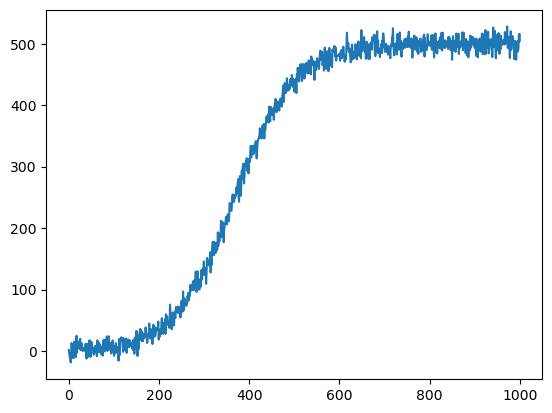

In [ ]:
# Load a forward model
model = execute_test_run(pars, Extra, )

# Create some toy data
real_parameters = [0.015, 500]
times = np.linspace(0, 1000, 1000)
org_values = model.simulate(real_parameters, times)

# Add noise
noise = 10
values = org_values + np.random.normal(0, noise, org_values.shape)
real_parameters = np.array(real_parameters + [noise])

# Get properties of the noise sample
noise_sample_mean = np.mean(values - org_values)
noise_sample_std = np.std(values - org_values)

# Create an object with links to the model and time series
problem = pints.SingleOutputProblem(model, times, values)

# Show the noisy data
plt.figure()
plt.plot(times, values)
plt.show()

In [ ]:
# Create a log-likelihood function (adds an extra parameter!)
log_likelihood = pints.GaussianLogLikelihood(problem)

# Create a uniform prior over both the parameters and the new noise variable
log_prior = pints.UniformLogPrior(
    [0.01, 400, noise * 0.1],
    [0.02, 600, noise * 100]
    )

# Create a posterior log-likelihood
log_posterior = pints.LogPosterior(log_likelihood, log_prior)

# Create a differential evolution MCMC routine
x0 = [
    real_parameters * 0.8,
    real_parameters * 0.9,
    real_parameters * 1.1,
]
mcmc = pints.MCMCController(log_posterior, 3, x0, method=pints.DreamMCMC)
mcmc.set_initial_phase_iterations(500)
mcmc.set_max_iterations(1000)
mcmc.set_log_to_screen(False)

C:\Users\made2928\AppData\Local\Temp\ipykernel_31732\942377684.py:5: DeprecationWarning: `product` is deprecated as of NumPy 1.25.0, and will be removed in NumPy 2.0. Please use `prod` instead.
  log_prior = pints.UniformLogPrior(


Run!

In [ ]:
# Run!
print('Running...')
chains = mcmc.run()
print('Done!')

Running...
Done!


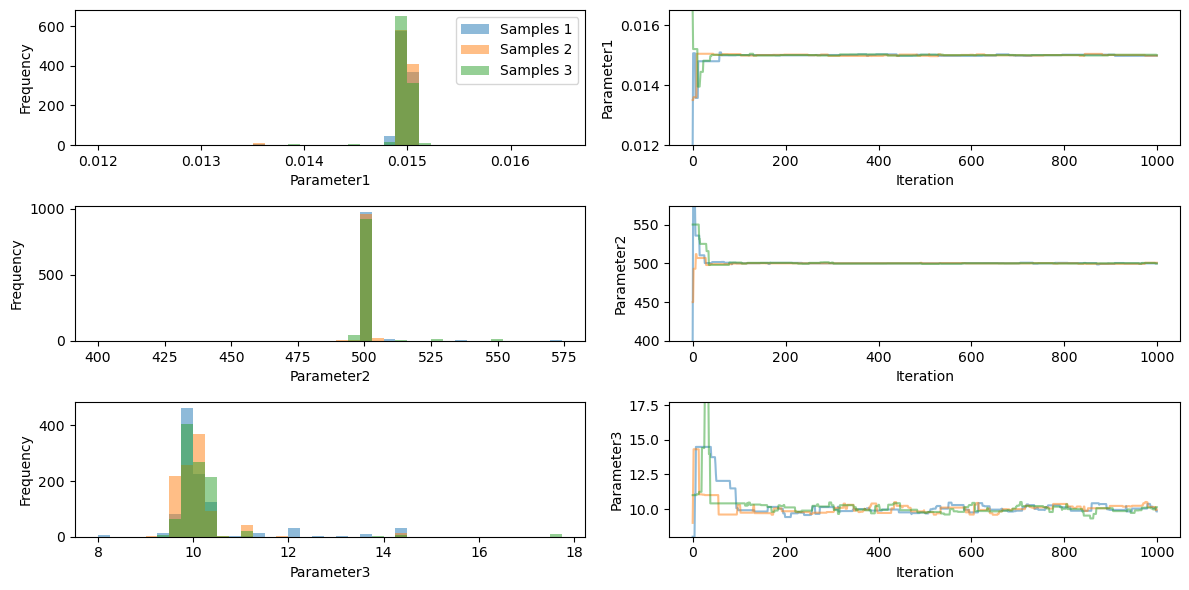

In [ ]:
pints.plot.trace(chains)
plt.show()

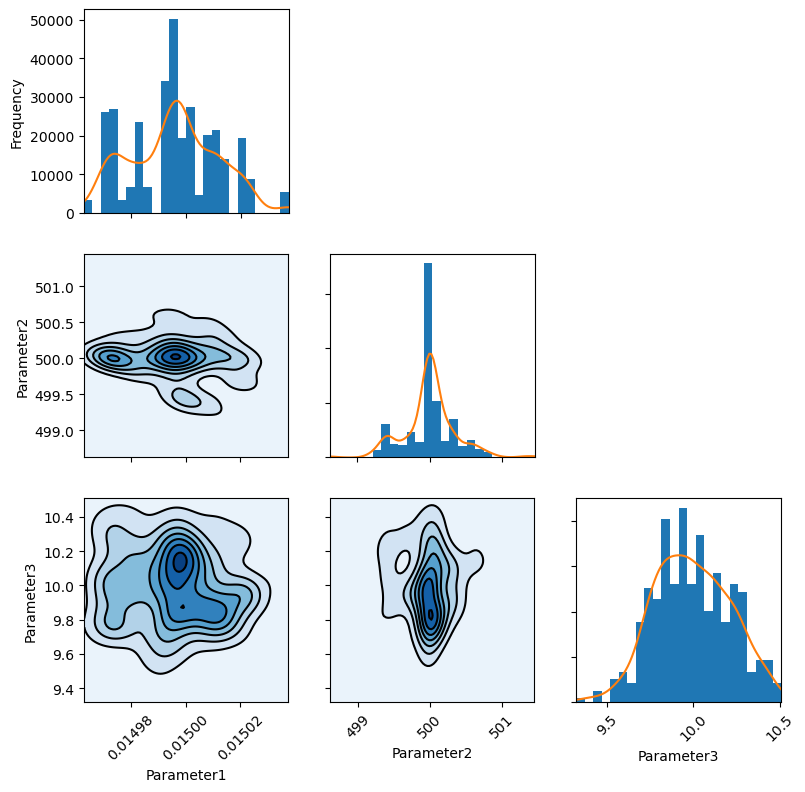

In [ ]:
# Plot output
stacked = np.vstack(chains[:, 200::5])
pints.plot.pairwise(stacked, kde=True)
plt.show()

In [ ]:
# Check convergence and other properties of chains
results = pints.MCMCSummary(chains=chains[:, 200:], time=mcmc.time(), parameter_names=['r', 'k', 'sigma'])
print(results)

param    mean    std.    2.5%    25%     50%     75%     97.5%    rhat    ess    ess per sec.
-------  ------  ------  ------  ------  ------  ------  -------  ------  -----  --------------
r        0.01    0.00    0.01    0.01    0.01    0.02    0.02     1.03    51.99  112.93
k        500.00  0.35    499.39  499.94  500.01  500.12  500.73   1.06    60.04  130.41
sigma    9.99    0.22    9.59    9.83    9.98    10.14   10.42    1.05    73.08  158.73
